In [1]:
import sys
import os
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir))
# Add parent directory to sys.path
sys.path.insert(0, parent_dir)
# Now you can import the module

import gptransform
import torch
import matplotlib.pyplot as plt
from pickle import dump,load
import time
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multivariate_normal import  MultivariateNormal
torch.set_default_dtype(torch.float64)
import pandas as pd

# Computes RDF from hoomd gsd file
def compute_simple_rdf(gsd_fname, rmin, rmax, bins, A_type_id = 0, B_type_id = 0):
    import freud
    import gsd.hoomd
    # Reads in traj and creates box from it
    traj = gsd.hoomd.open(gsd_fname, 'r')
    box = freud.box.Box.from_box(traj[0].configuration.box[:3])
    rdf = freud.density.RDF(bins=bins, r_min = rmin, r_max=rmax)
    typeid = traj[0].particles.typeid
    
    for frame in traj:
        rdf.compute(system=(box, (frame.particles.position[(np.where(typeid == A_type_id))])), query_points=(frame.particles.position[(np.where(typeid == B_type_id))]), reset=False)
    return rdf.bin_centers, rdf.rdf

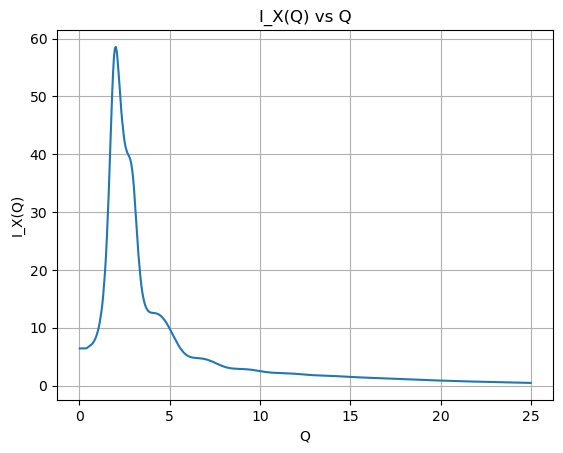

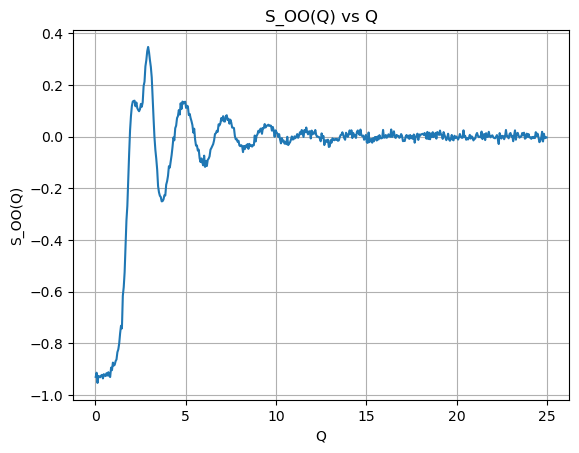

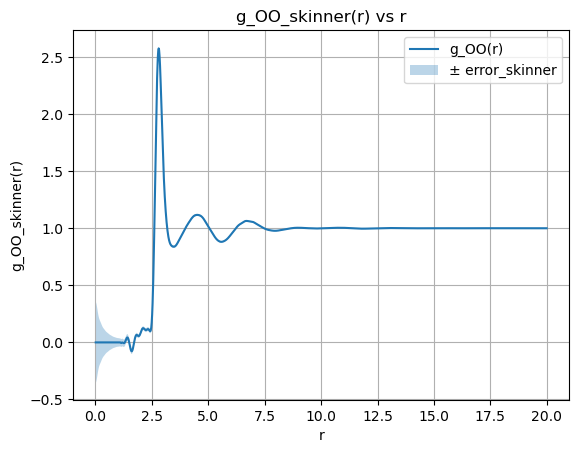

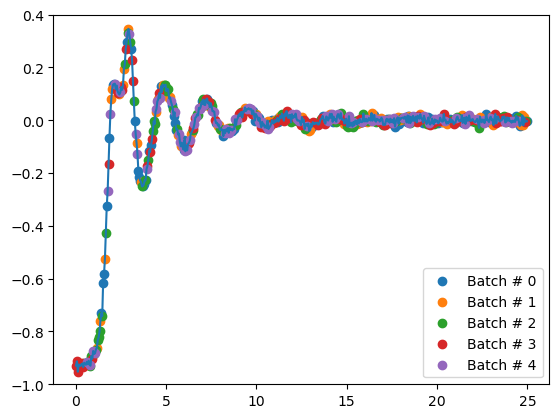

In [2]:
# Load the data
file_path = 'Datasets/Ambient_water_xray_data.txt'
df = pd.read_csv(file_path, sep='\t', skiprows=12, names=[
    'Q', 'I_X(Q)', 'S_OO(Q)', 'r', 'g_OO(r)', 'error'
])

# Convert to PyTorch tensors
Q = torch.tensor(df['Q'].values, dtype=torch.float32)[1:1001:2]
I_X = torch.tensor(df['I_X(Q)'].values, dtype=torch.float32)[1:1001:2]
S_OO = torch.tensor(df['S_OO(Q)'].values, dtype=torch.float32)[1:1001:2] - 1 + 0.01*torch.randn(Q.size())
r = torch.tensor(df['r'].values, dtype=torch.float32)[1:]
g_OO_skinner = torch.tensor(df['g_OO(r)'].values, dtype=torch.float32)[1:]
error_skinner = torch.tensor(df['error'].values, dtype=torch.float32)[1:]

# Plot I_X(Q) vs Q
plt.figure()
plt.plot(Q, I_X)
plt.xlabel('Q')
plt.ylabel('I_X(Q)')
plt.title('I_X(Q) vs Q')
plt.grid(True)
plt.show()

# Plot S_OO(Q) vs Q
plt.figure()
plt.plot(Q, S_OO)
plt.xlabel('Q')
plt.ylabel('S_OO(Q)')
plt.title('S_OO(Q) vs Q')
plt.grid(True)
plt.show()

# Plot g_OO(r) vs r
plt.figure()
plt.plot(r, g_OO_skinner, label='g_OO(r)')
plt.xlabel('r')
plt.ylabel('g_OO_skinner(r)')
plt.title('g_OO_skinner(r) vs r')
plt.grid(True)

# Add transparent error fill
plt.fill_between(r, g_OO_skinner - error_skinner, g_OO_skinner + error_skinner, alpha=0.3, label='± error_skinner')
plt.legend()
plt.show()
    
perm = torch.randperm(len(S_OO))
q_values = Q.reshape(len(Q),1)
q_train = Q.reshape(len(Q),1)
q_infer = Q.reshape(len(Q),1)
r_grid = r.reshape(len(r),1)
r_infer = r.reshape(len(r),1)
sq_train = S_OO.reshape(len(Q),1)

# Put into Pytorch Dataloader
dataset_OO = gptransform.data(q_values[perm].reshape(5,100,1),S_OO[perm].reshape(5,100,1))

for batch, (X, y) in enumerate(dataset_OO):
    # Compute prediction and loss
    plt.scatter(X[0], y[0],label="Batch # " + str(batch))
plt.plot(q_values,sq_train)
plt.ylim(-1,0.4)
plt.legend()
plt.show()

density = 0.1/3

Average loss: -161.742065  [    0/  150]
l:       1.053783 
max:     0.264501 
slope:   15.676609 
loc:     2.562993 
decay:   0.294505 
sigma_n: 0.034251 
r_0:     2.459870 
s:       22.215534 
Minutes Taken Since Last Report: 0.167633 



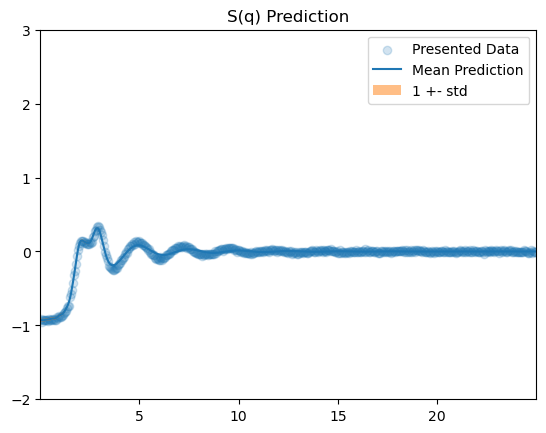

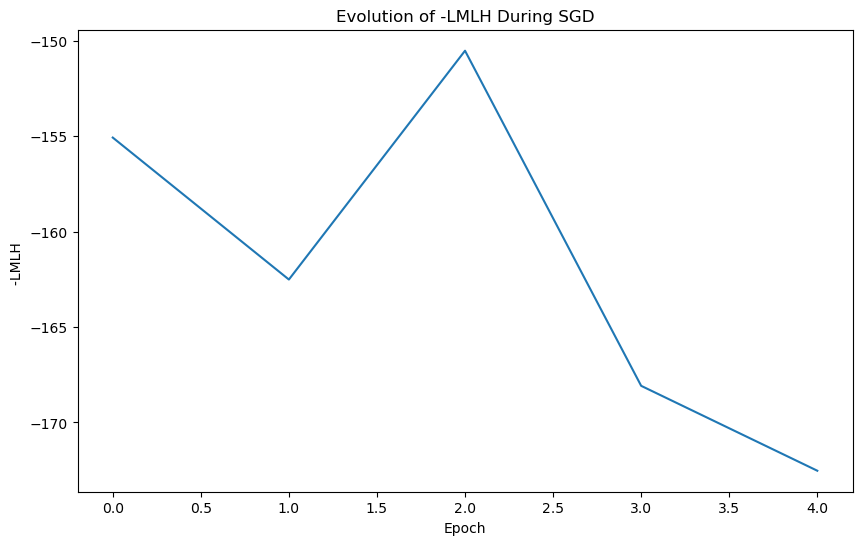

Average loss: -268.495341  [   25/  150]
l:       0.454943 
max:     1.107392 
slope:   13.038466 
loc:     2.647784 
decay:   0.752642 
sigma_n: 0.011473 
r_0:     2.685097 
s:       45.760626 
Minutes Taken Since Last Report: 5.600504 



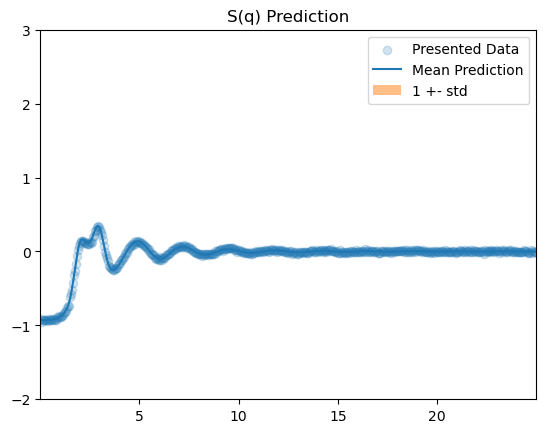

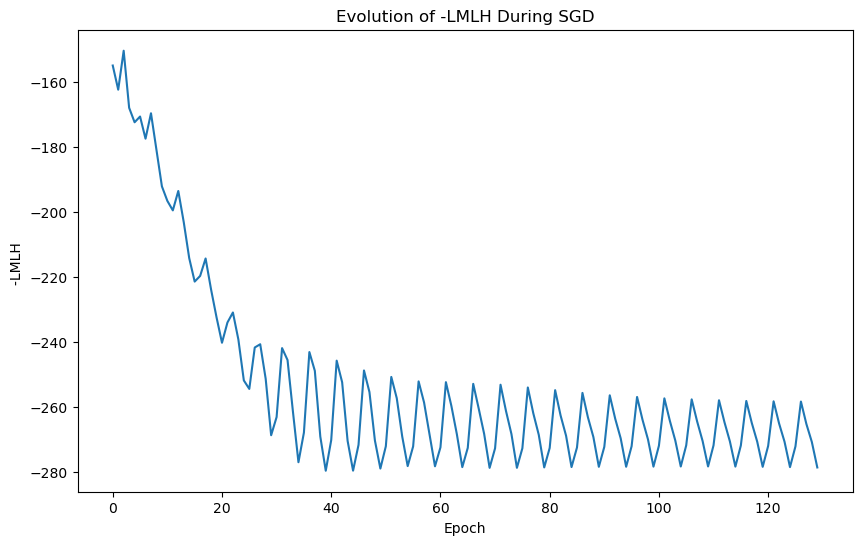

Average loss: -270.027778  [   50/  150]
l:       0.561146 
max:     1.760130 
slope:   13.037904 
loc:     2.671709 
decay:   0.855757 
sigma_n: 0.011418 
r_0:     2.687962 
s:       47.879253 
Minutes Taken Since Last Report: 5.962836 



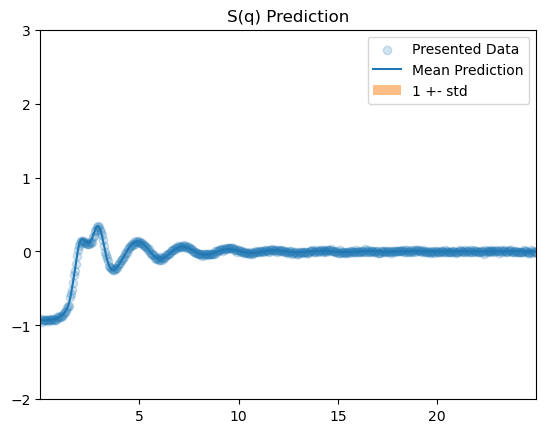

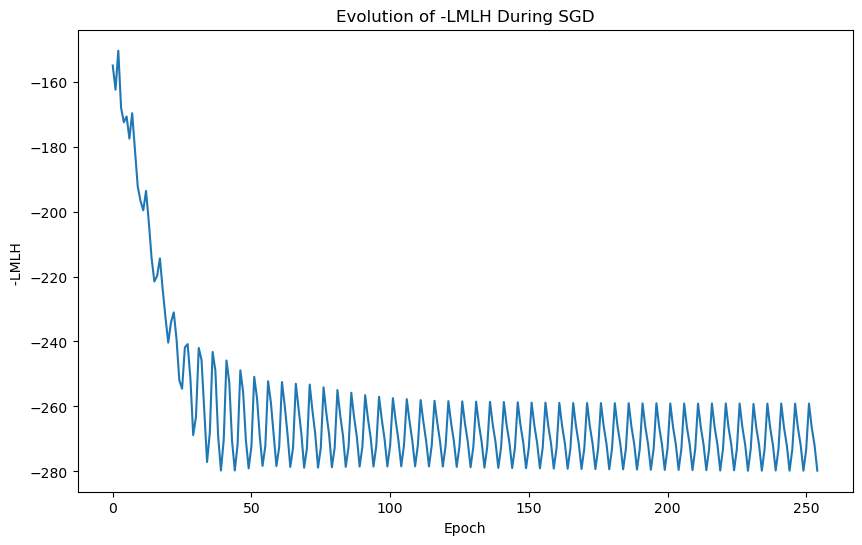

Average loss: -270.230128  [   75/  150]
l:       0.585699 
max:     2.009765 
slope:   12.993174 
loc:     2.678125 
decay:   0.886204 
sigma_n: 0.011374 
r_0:     2.687766 
s:       48.580592 
Minutes Taken Since Last Report: 4.911273 



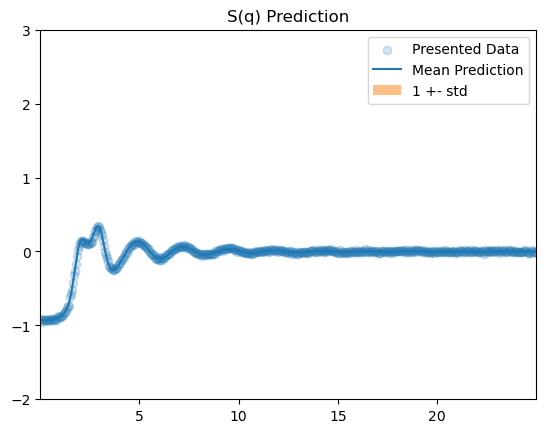

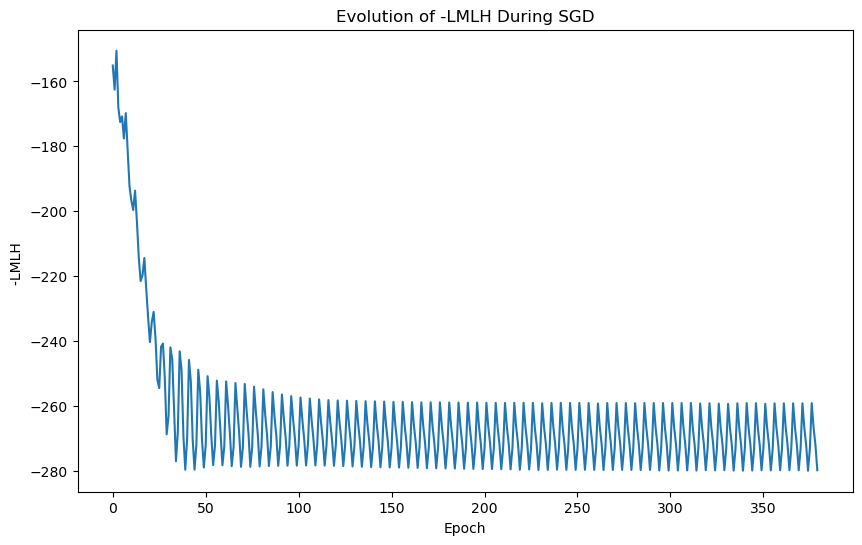

Average loss: -270.261449  [  100/  150]
l:       0.591547 
max:     2.088126 
slope:   12.963253 
loc:     2.680244 
decay:   0.896188 
sigma_n: 0.011383 
r_0:     2.687729 
s:       48.929489 
Minutes Taken Since Last Report: 3.814229 



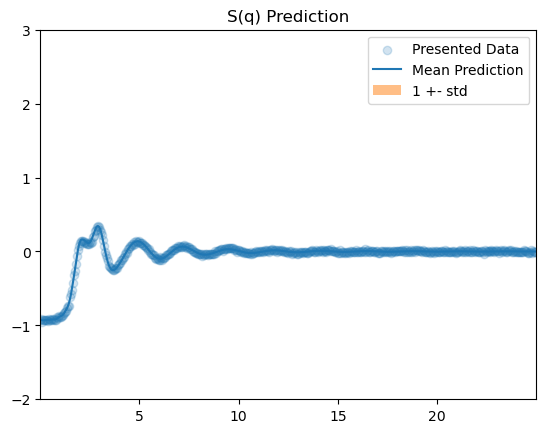

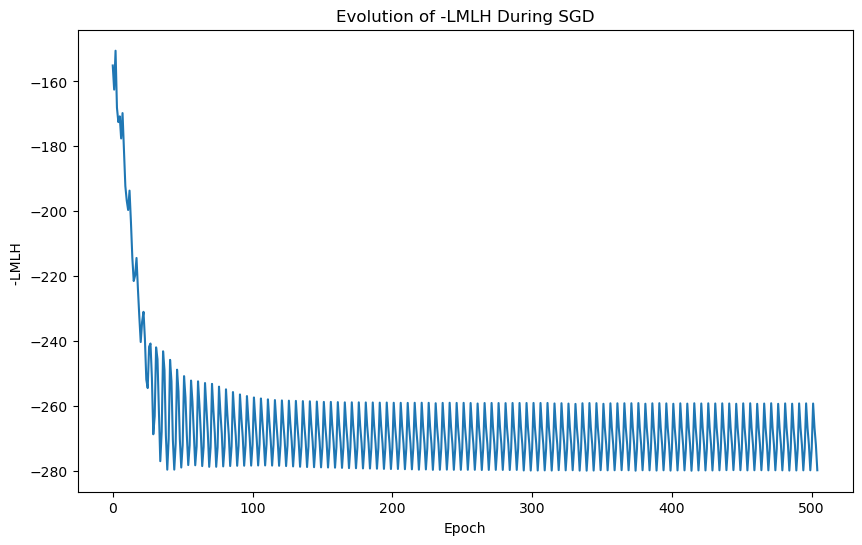

Average loss: -270.294573  [  125/  150]
l:       0.592953 
max:     2.113325 
slope:   12.961300 
loc:     2.680902 
decay:   0.899832 
sigma_n: 0.011353 
r_0:     2.687839 
s:       49.136799 
Minutes Taken Since Last Report: 5.603469 



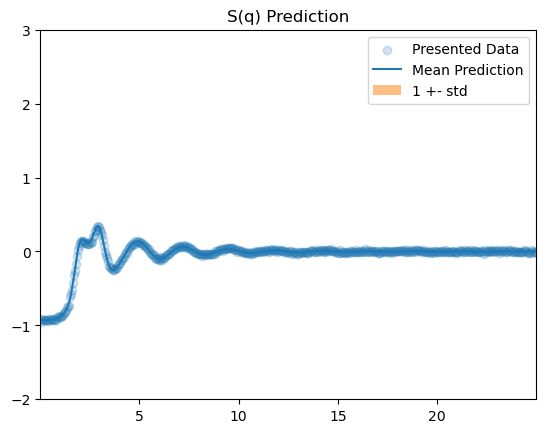

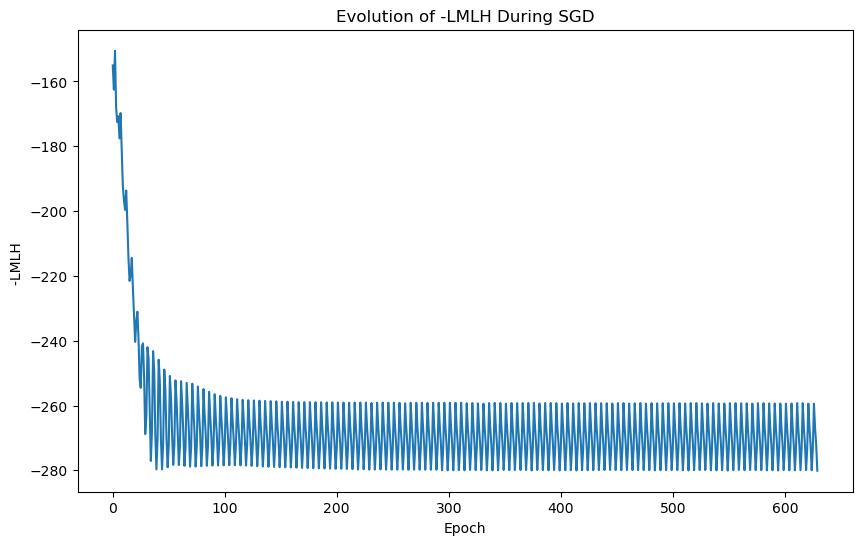

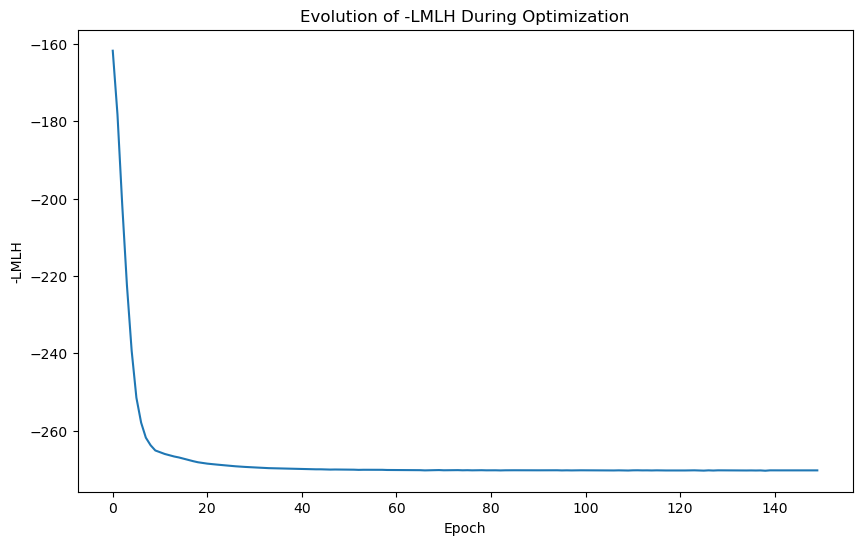

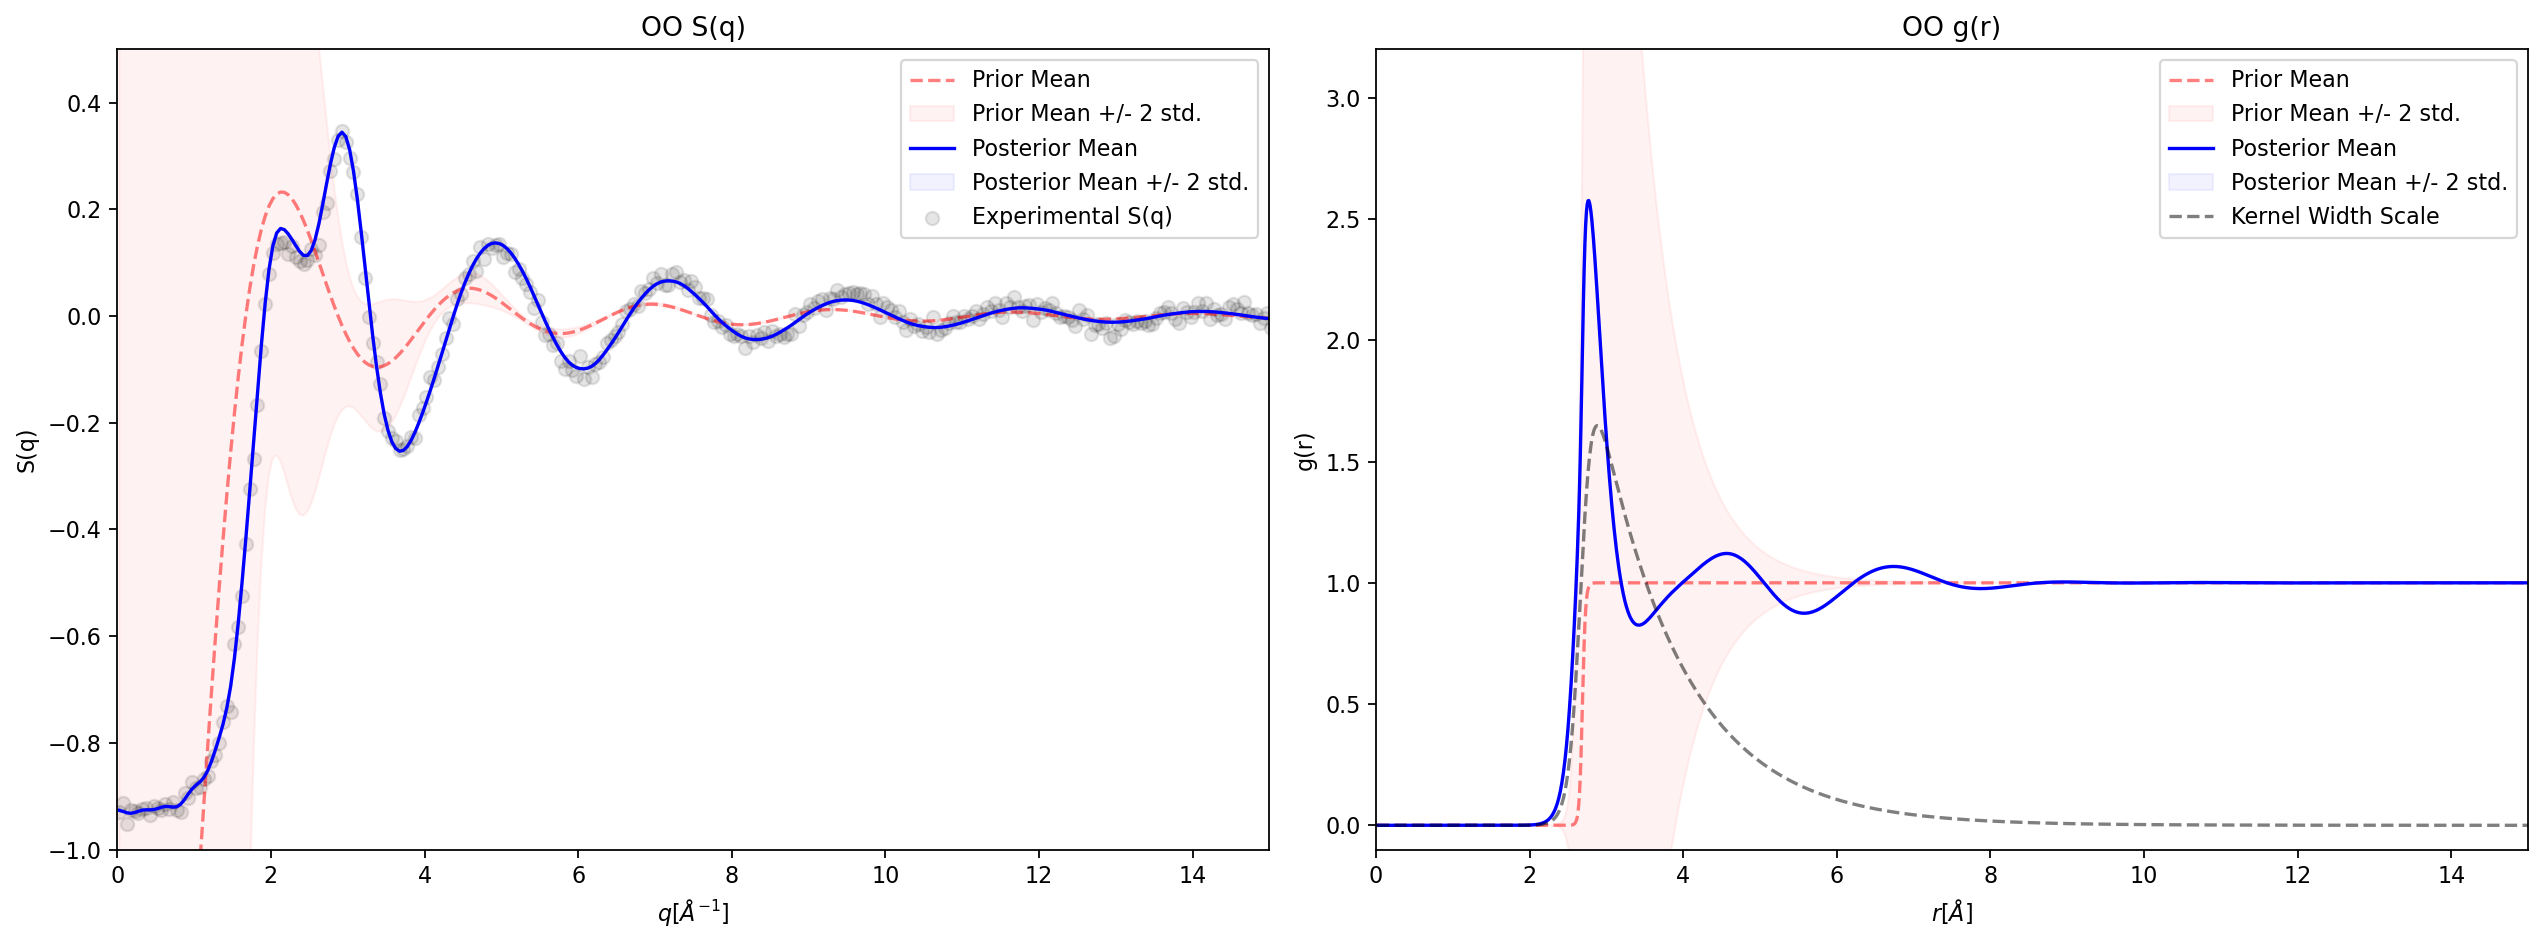

In [3]:
psq_name = 'OO'

init_param_bounds = torch.zeros((8,2)).detach().cpu()

### Width Function Params ###

# Ell
init_param_bounds[0,1] = 2.5
init_param_bounds[0,0] = 0.1


# Max
init_param_bounds[1,1] = 15
init_param_bounds[1,0] = 0.2

# Slope
init_param_bounds[2,1] = 30
init_param_bounds[2,0] = 1

# Loc
init_param_bounds[3,1] = 6
init_param_bounds[3,0] = 0.5

# Decay
init_param_bounds[4,1] = 1
init_param_bounds[4,0] = 0.05

### Experimental Noise ###

# Sigma_n
init_param_bounds[5,1] = 0.5
init_param_bounds[5,0] = 0.0001

### Non-Bonded Peaks in Mean ###

# r_0
init_param_bounds[6,1] = 6
init_param_bounds[6,0] = 0.5

# s
init_param_bounds[7,1] = 50
init_param_bounds[7,0] = 0.1

# Create initial parameters
init_params = torch.sum(init_param_bounds,dim=1)/2
init_params = torch.tensor([1.2000,  0.2500, 14.0631,  2.5000,  0.3000,  0.0403,  2.5000, 20.0000])

# Create GP Object
gp = gptransform.GP(init_params, init_param_bounds, 0, density, 69)

# Perform hyper parameter optimization
# optimizer = torch.optim.SGD(gp.parameters(), lr=5e-5)
optimizer = torch.optim.AdamW(gp.parameters(), lr=5e-2)
losses = gptransform.train_loop(dataset_OO, gp, optimizer, 150, r_grid, q_values,  sq_train, q_infer, r_infer, -2,3, -0.1,3.1)

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(torch.tensor(losses).view(150, 5).mean(dim=1), linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('-LMLH')
plt.title('Evolution of -LMLH During Optimization')
plt.savefig('figs/'+psq_name+'_LMLH.png')
plt.show()

# Save GP
torch.save(gp, 'models/'+psq_name+'_GP')

with torch.no_grad():

    fig, axs = plt.subplots(1, 2, figsize=(16, 6), dpi=160)

    # First Plot: S(q)
    Σ_q_prior = gp.K_qq(r_grid,r_grid,q_infer,q_infer).detach()
    μ_q_prior = gp.mean_q(r_grid,q_infer).detach()
    μ_q_post, Σ_q_post = gp.predict_sq_trapz(r_grid, q_infer, q_train, sq_train,adjust=False)
    μ_q_post = μ_q_post.detach()
    Σ_q_post = Σ_q_post.detach()

    axs[0].plot(q_infer.T[0], μ_q_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
    axs[0].fill_between(q_infer.T[0], μ_q_prior.T[0] + 2*torch.diag(Σ_q_prior), μ_q_prior.T[0] - 2*torch.diag(Σ_q_prior), alpha=0.05, label="Prior Mean +/- 2 std.", color='r')
    axs[0].plot(q_infer.T[0], μ_q_post.T[0], label="Posterior Mean", color='b')
    axs[0].fill_between(q_infer.T[0], μ_q_post.T[0] + 2*torch.diag(Σ_q_post), μ_q_post.T[0] - 2*torch.diag(Σ_q_post), alpha=0.05, label="Posterior Mean +/- 2 std.", color='b')
    axs[0].scatter(q_train, sq_train, label='Experimental S(q)', alpha=0.1, color='k')
    axs[0].set_xlim(0, 15)
    axs[0].set_ylim(-1,0.5)
    axs[0].set_title(psq_name + ' S(q)')
    axs[0].set_xlabel('$q [Å^{-1}]$')
    axs[0].set_ylabel('S(q)')
    axs[0].legend()

    # Second Plot: g(r)
    Σ_r_prior = gp.K_rr(r_infer,r_infer).detach()
    μ_r_prior = gp.mean_r(r_infer).detach()
    μ_r_post, Σ_r_post = gp.predict_rdf_trapz(r_grid, r_infer, q_train, sq_train,adjust=False)
    μ_r_post = μ_r_post.detach()
    Σ_r_post = Σ_r_post.detach()

    axs[1].plot(r_infer.T[0], μ_r_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
    axs[1].fill_between(r_infer.T[0], μ_r_prior.T[0] + 2*torch.diag(Σ_r_prior), μ_r_prior.T[0] - 2*torch.diag(Σ_r_prior), alpha=0.05, label="Prior Mean +/- 2 std.", color='r')
    axs[1].plot(r_infer.T[0], μ_r_post.T[0], label="Posterior Mean", color='b')
    axs[1].fill_between(r_infer.T[0], μ_r_post.T[0] + 2*torch.diag(Σ_r_post), μ_r_post.T[0] - 2*torch.diag(Σ_r_post), alpha=0.05, label="Posterior Mean +/- 2 std.", color='b')
#                     axs[1].plot(r_infer.T[0],gp.length_fxn(r_infer.T[0],gp.theta[0],gp.theta[1],gp.theta[2]).detach(),label='Kernel Length Scale',linestyle='dashed',color='rebeccapurple',alpha=0.5)
    axs[1].plot(r_infer.T[0],gp.width_fxn(r_infer.T[0],gp.theta[1],gp.theta[2],gp.theta[3],gp.theta[4]).detach(),label='Kernel Width Scale',linestyle='dashed',color='k',alpha=0.5)
    axs[1].set_ylim(-0.1, 3.2)
    axs[1].set_xlim(0, 15)
    axs[1].set_title(psq_name + ' g(r)')
    axs[1].set_xlabel('$r [Å]$')
    axs[1].set_ylabel('g(r)')
    axs[1].legend()

    plt.tight_layout()
    plt.savefig('figs/'+psq_name+'_post.png')
    plt.show()

l:       0.593218 
max:     2.122030 
slope:   12.941036 
loc:     2.681008 
decay:   0.901226 
sigma_n: 0.011361 
r_0:     2.687952 
s:       49.269007 


<Figure size 2400x1800 with 0 Axes>

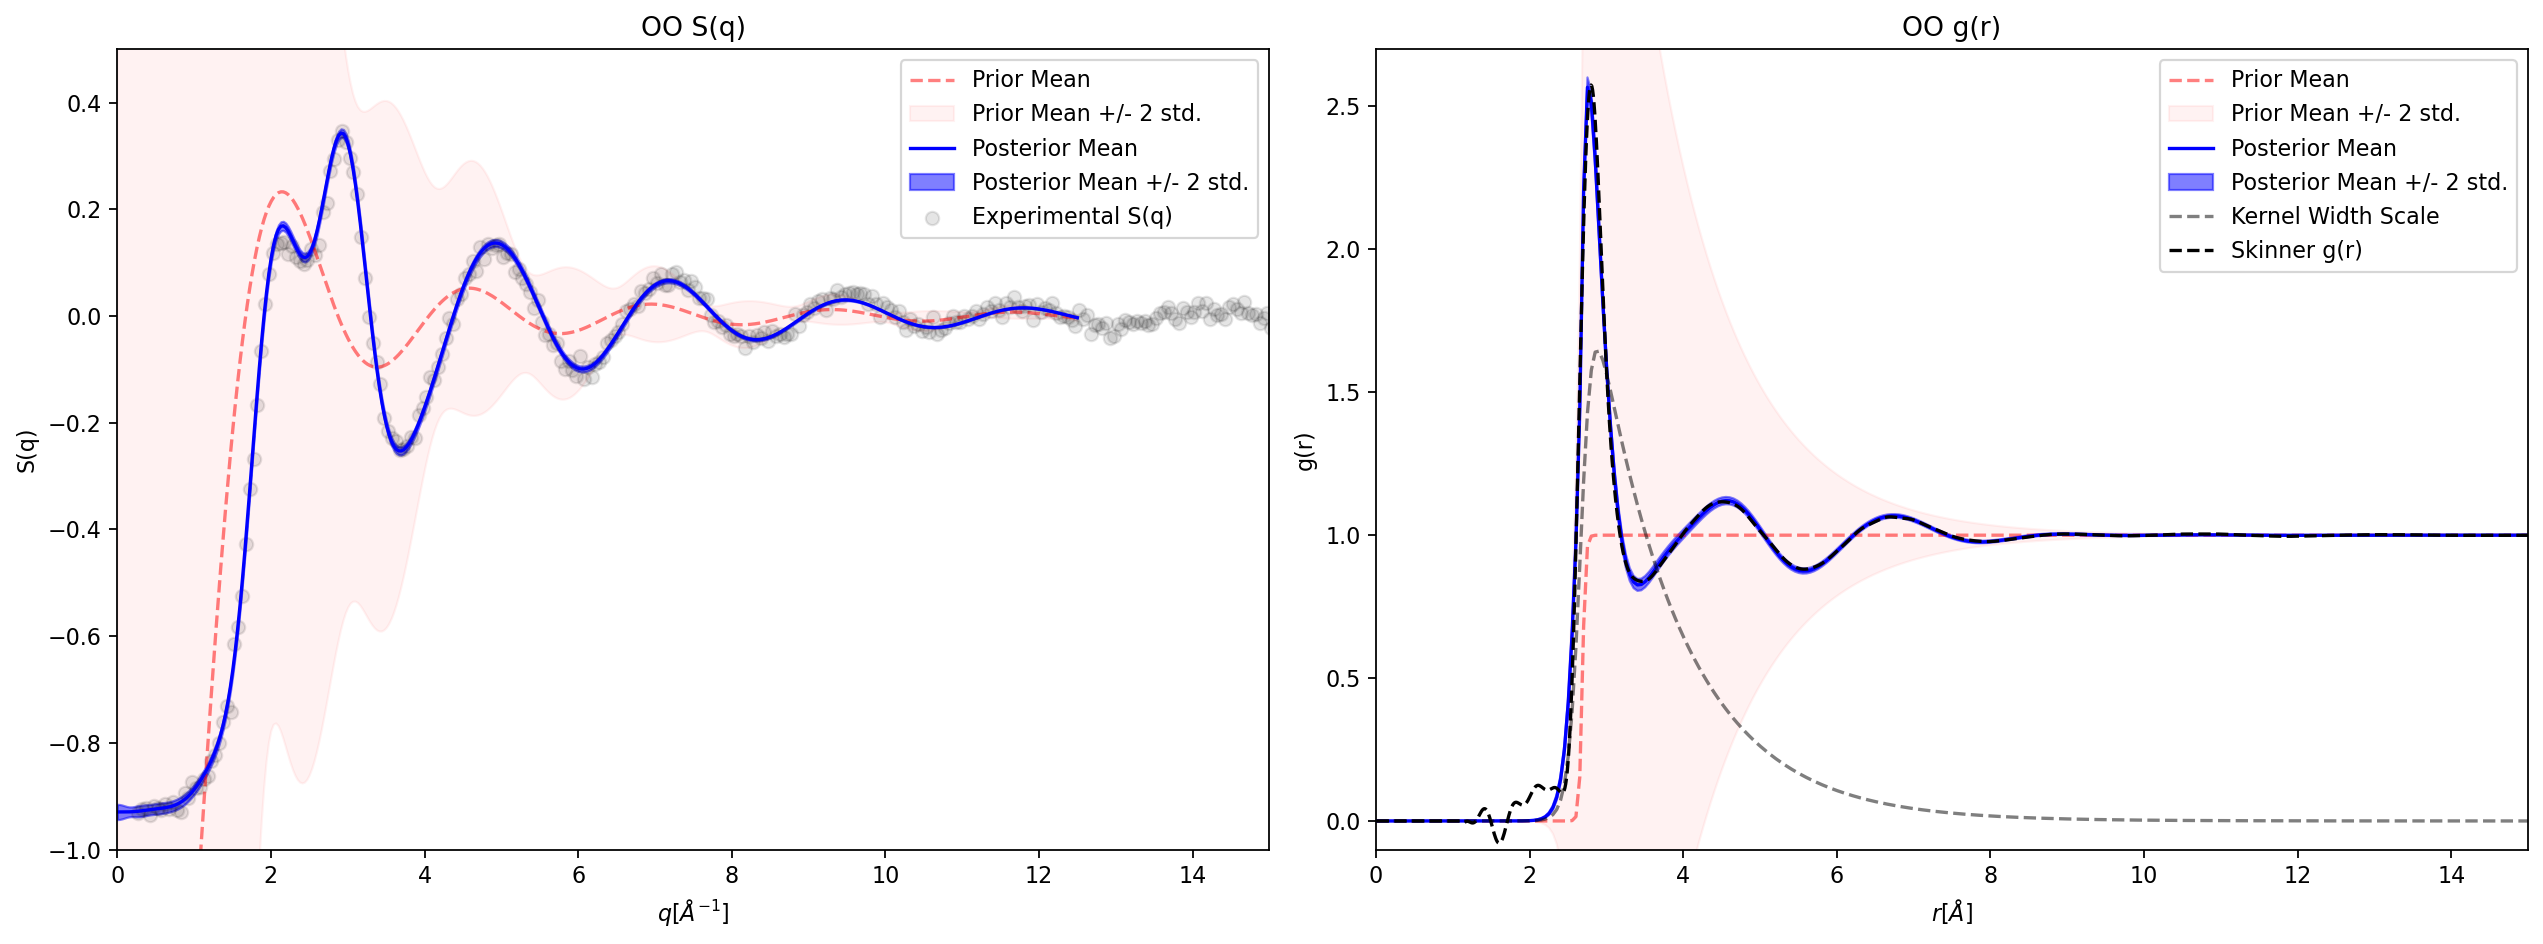

In [10]:
gp.print_params()
with torch.no_grad():
    
    r_grid =  torch.linspace(0.0001, 40, 800).reshape(-1,1)
    r_infer = torch.linspace(0.0001, 40, 800).reshape(-1,1)
    plt.figure(figsize=(8, 6), dpi=300)
        
    q_infer = torch.linspace(0.0001, 12.5,400).reshape(-1,1)

    fig, axs = plt.subplots(1, 2, figsize=(16, 6), dpi=160)

    # First Plot: S(q)
    Σ_q_prior = gp.K_qq(r_grid,r_grid,q_infer,q_infer).detach()
    μ_q_prior = gp.mean_q(r_grid,q_infer).detach()
    μ_q_post, Σ_q_post = gp.predict_sq_trapz(r_grid, q_infer, q_train, sq_train,adjust=False)
    μ_q_post = μ_q_post.detach()
    Σ_q_post = Σ_q_post.detach()

    axs[0].plot(q_infer.T[0], μ_q_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
    axs[0].fill_between(q_infer.T[0], μ_q_prior.T[0] + 2*torch.diag(Σ_q_prior)**0.5, μ_q_prior.T[0] - 2*torch.diag(Σ_q_prior)**0.5, alpha=0.05, label="Prior Mean +/- 2 std.", color='r')
    axs[0].plot(q_infer.T[0], μ_q_post.T[0], label="Posterior Mean", color='b')
    axs[0].fill_between(q_infer.T[0], μ_q_post.T[0] + 2*torch.diag(Σ_q_post)**0.5, μ_q_post.T[0] - 2*torch.diag(Σ_q_post)**0.5, alpha=0.5, label="Posterior Mean +/- 2 std.", color='b')
    axs[0].scatter(q_train[5:], sq_train[5:], label='Experimental S(q)', alpha=0.1, color='k')
    axs[0].set_xlim(0, 15)
    axs[0].set_ylim(-1,0.5)
    axs[0].set_title(psq_name + ' S(q)')
    axs[0].set_xlabel('$q [Å^{-1}]$')
    axs[0].set_ylabel('S(q)')
    axs[0].legend()

    # Second Plot: g(r)
    Σ_r_prior = gp.K_rr(r_infer,r_infer).detach()
    μ_r_prior = gp.mean_r(r_infer).detach()
    μ_r_post, Σ_r_post = gp.predict_rdf_trapz(r_grid, r_infer, q_train, sq_train,adjust=False)
    μ_r_post = μ_r_post.detach()
    Σ_r_post = Σ_r_post.detach()

    axs[1].plot(r_infer.T[0], μ_r_prior.T[0], label="Prior Mean", linestyle='dashed', alpha=0.5, color='r')
    axs[1].fill_between(r_infer.T[0], μ_r_prior.T[0] + 2*torch.diag(Σ_r_prior)**0.5, μ_r_prior.T[0] - 2*torch.diag(Σ_r_prior)**0.5, alpha=0.05, label="Prior Mean +/- 2 std.", color='r')
    axs[1].plot(r_infer.T[0], μ_r_post.T[0], label="Posterior Mean", color='b')
    axs[1].fill_between(r_infer.T[0], μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5, alpha=0.5, label="Posterior Mean +/- 2 std.", color='b')
#                     axs[1].plot(r_infer.T[0],gp.length_fxn(r_infer.T[0],gp.theta[0],gp.theta[1],gp.theta[2]).detach(),label='Kernel Length Scale',linestyle='dashed',color='rebeccapurple',alpha=0.5)
    axs[1].plot(r_infer.T[0],gp.width_fxn(r_infer.T[0],gp.theta[1],gp.theta[2],gp.theta[3],gp.theta[4]).detach(),label='Kernel Width Scale',linestyle='dashed',color='k',alpha=0.5)
    axs[1].set_ylim(-0.1, 2.7)
    axs[1].plot(r,g_OO_skinner,label='Skinner g(r)',linestyle='dashed',color='k')
    axs[1].set_xlim(0, 15)
    axs[1].set_title(psq_name + ' g(r)')
    axs[1].set_xlabel('$r [Å]$')
    axs[1].set_ylabel('g(r)')
    axs[1].legend()

    plt.tight_layout()
    plt.savefig('figs/'+psq_name+'_post.png')
    plt.show()

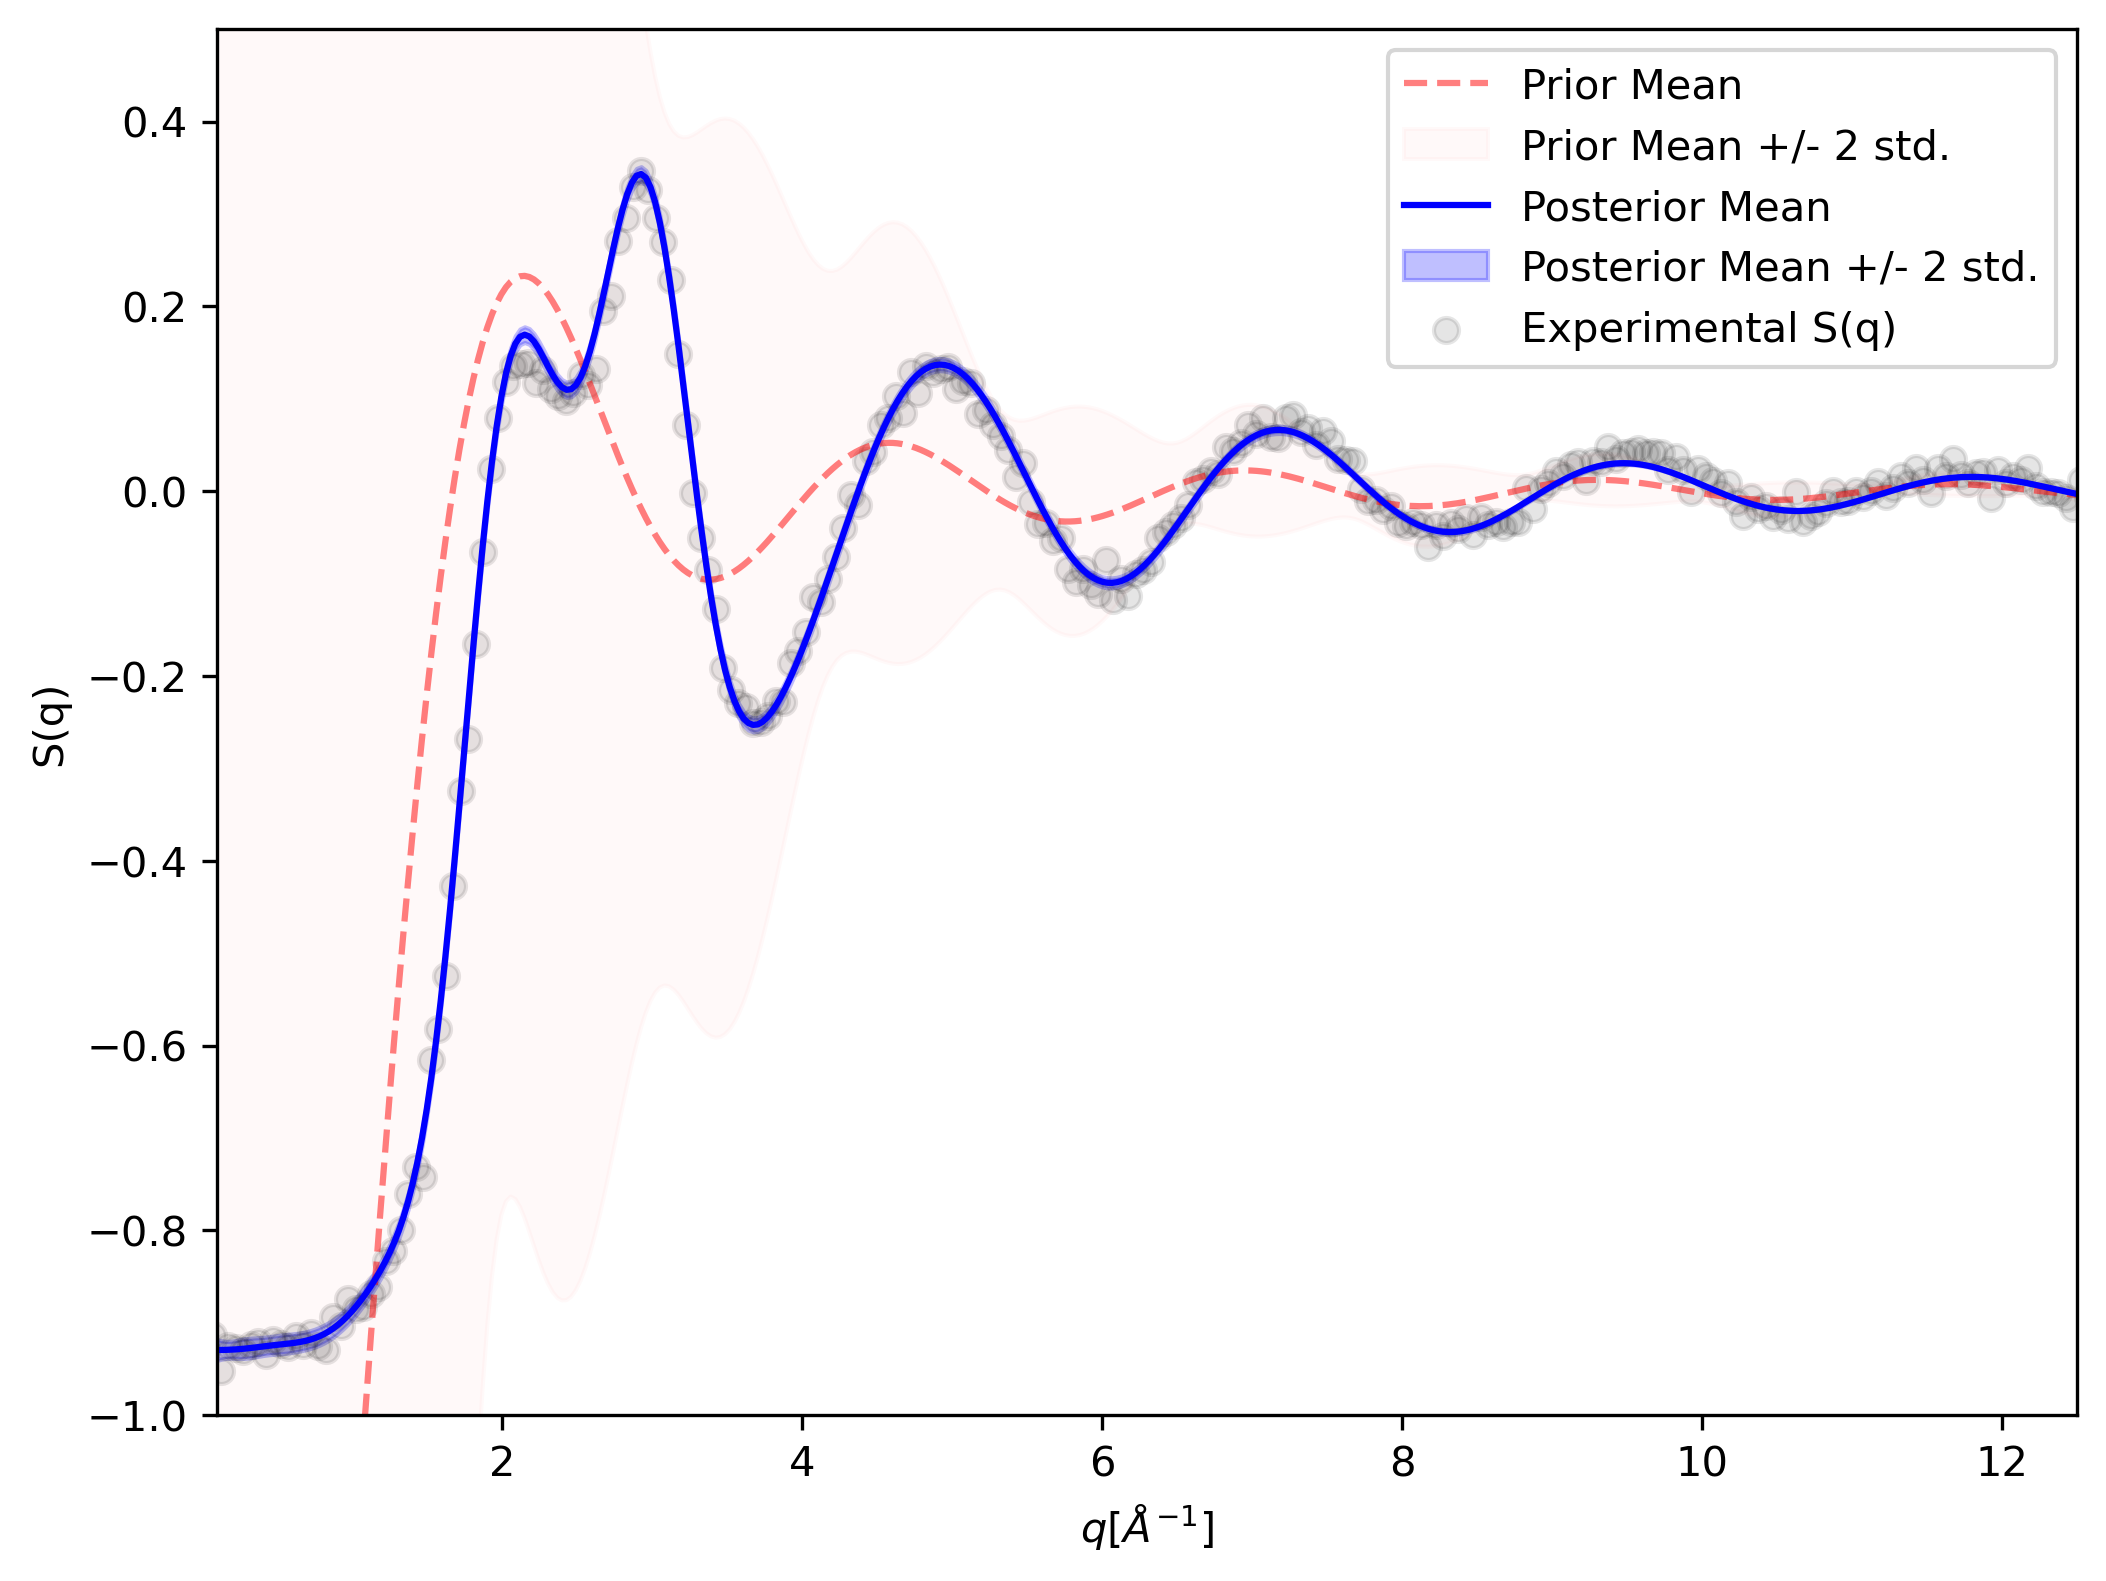

In [5]:
with torch.no_grad():

    q_infer = torch.linspace(0.1, 12.5,400).reshape(-1,1)
    # Calculate Prior Mean and Cov
    Σ_q_prior = gp.K_qq(r_grid,r_grid,q_infer,q_infer).detach()
    μ_q_prior = gp.mean_q(r_grid,q_infer).detach()

    # Calculate Posterior Mean and Cov
    μ_q_post, Σ_q_post = gp.predict_sq_trapz(r_grid, q_infer, q_train, sq_train,adjust=False)
    μ_q_post = μ_q_post.detach()
    Σ_q_post = Σ_q_post.detach()
    
    r_grid =  torch.linspace(0.0001, 40, 400).reshape(-1,1)
    r_infer = torch.linspace(0.0001, 40, 400).reshape(-1,1)
    plt.figure(figsize=(8, 6), dpi=300)
    # Plot Prior
    plt.plot(q_infer.T[0],μ_q_prior.T[0],label="Prior Mean",linestyle='dashed',alpha=0.5,color='r')
    plt.fill_between(q_infer.T[0],μ_q_prior.T[0] + 2*torch.diag(Σ_q_prior)**0.5, μ_q_prior.T[0] - 2*torch.diag(Σ_q_prior)**0.5,alpha=0.025,label="Prior Mean +/- 2 std.",color='r')

    # Plot Posterior
    plt.plot(q_infer.T[0],μ_q_post.T[0],label="Posterior Mean",color='b')
    plt.fill_between(q_infer.T[0],μ_q_post.T[0] + 2*torch.diag(Σ_q_post)**0.5, μ_q_post.T[0] - 2*torch.diag(Σ_q_post)**0.5,alpha=0.25,label="Posterior Mean +/- 2 std.",color='b')
    # Experimental Data
    plt.scatter(q_train,sq_train,label='Experimental S(q)',alpha=0.1,color='k')

    # Plot Settings
    plt.xlim(0.1,12.5)
    plt.ylim(-1,0.5)
    plt.xlabel('$q [Å^{-1}]$')
    plt.ylabel('S(q)')
    plt.legend()
    plt.savefig("figs/OO_sq_post.png")

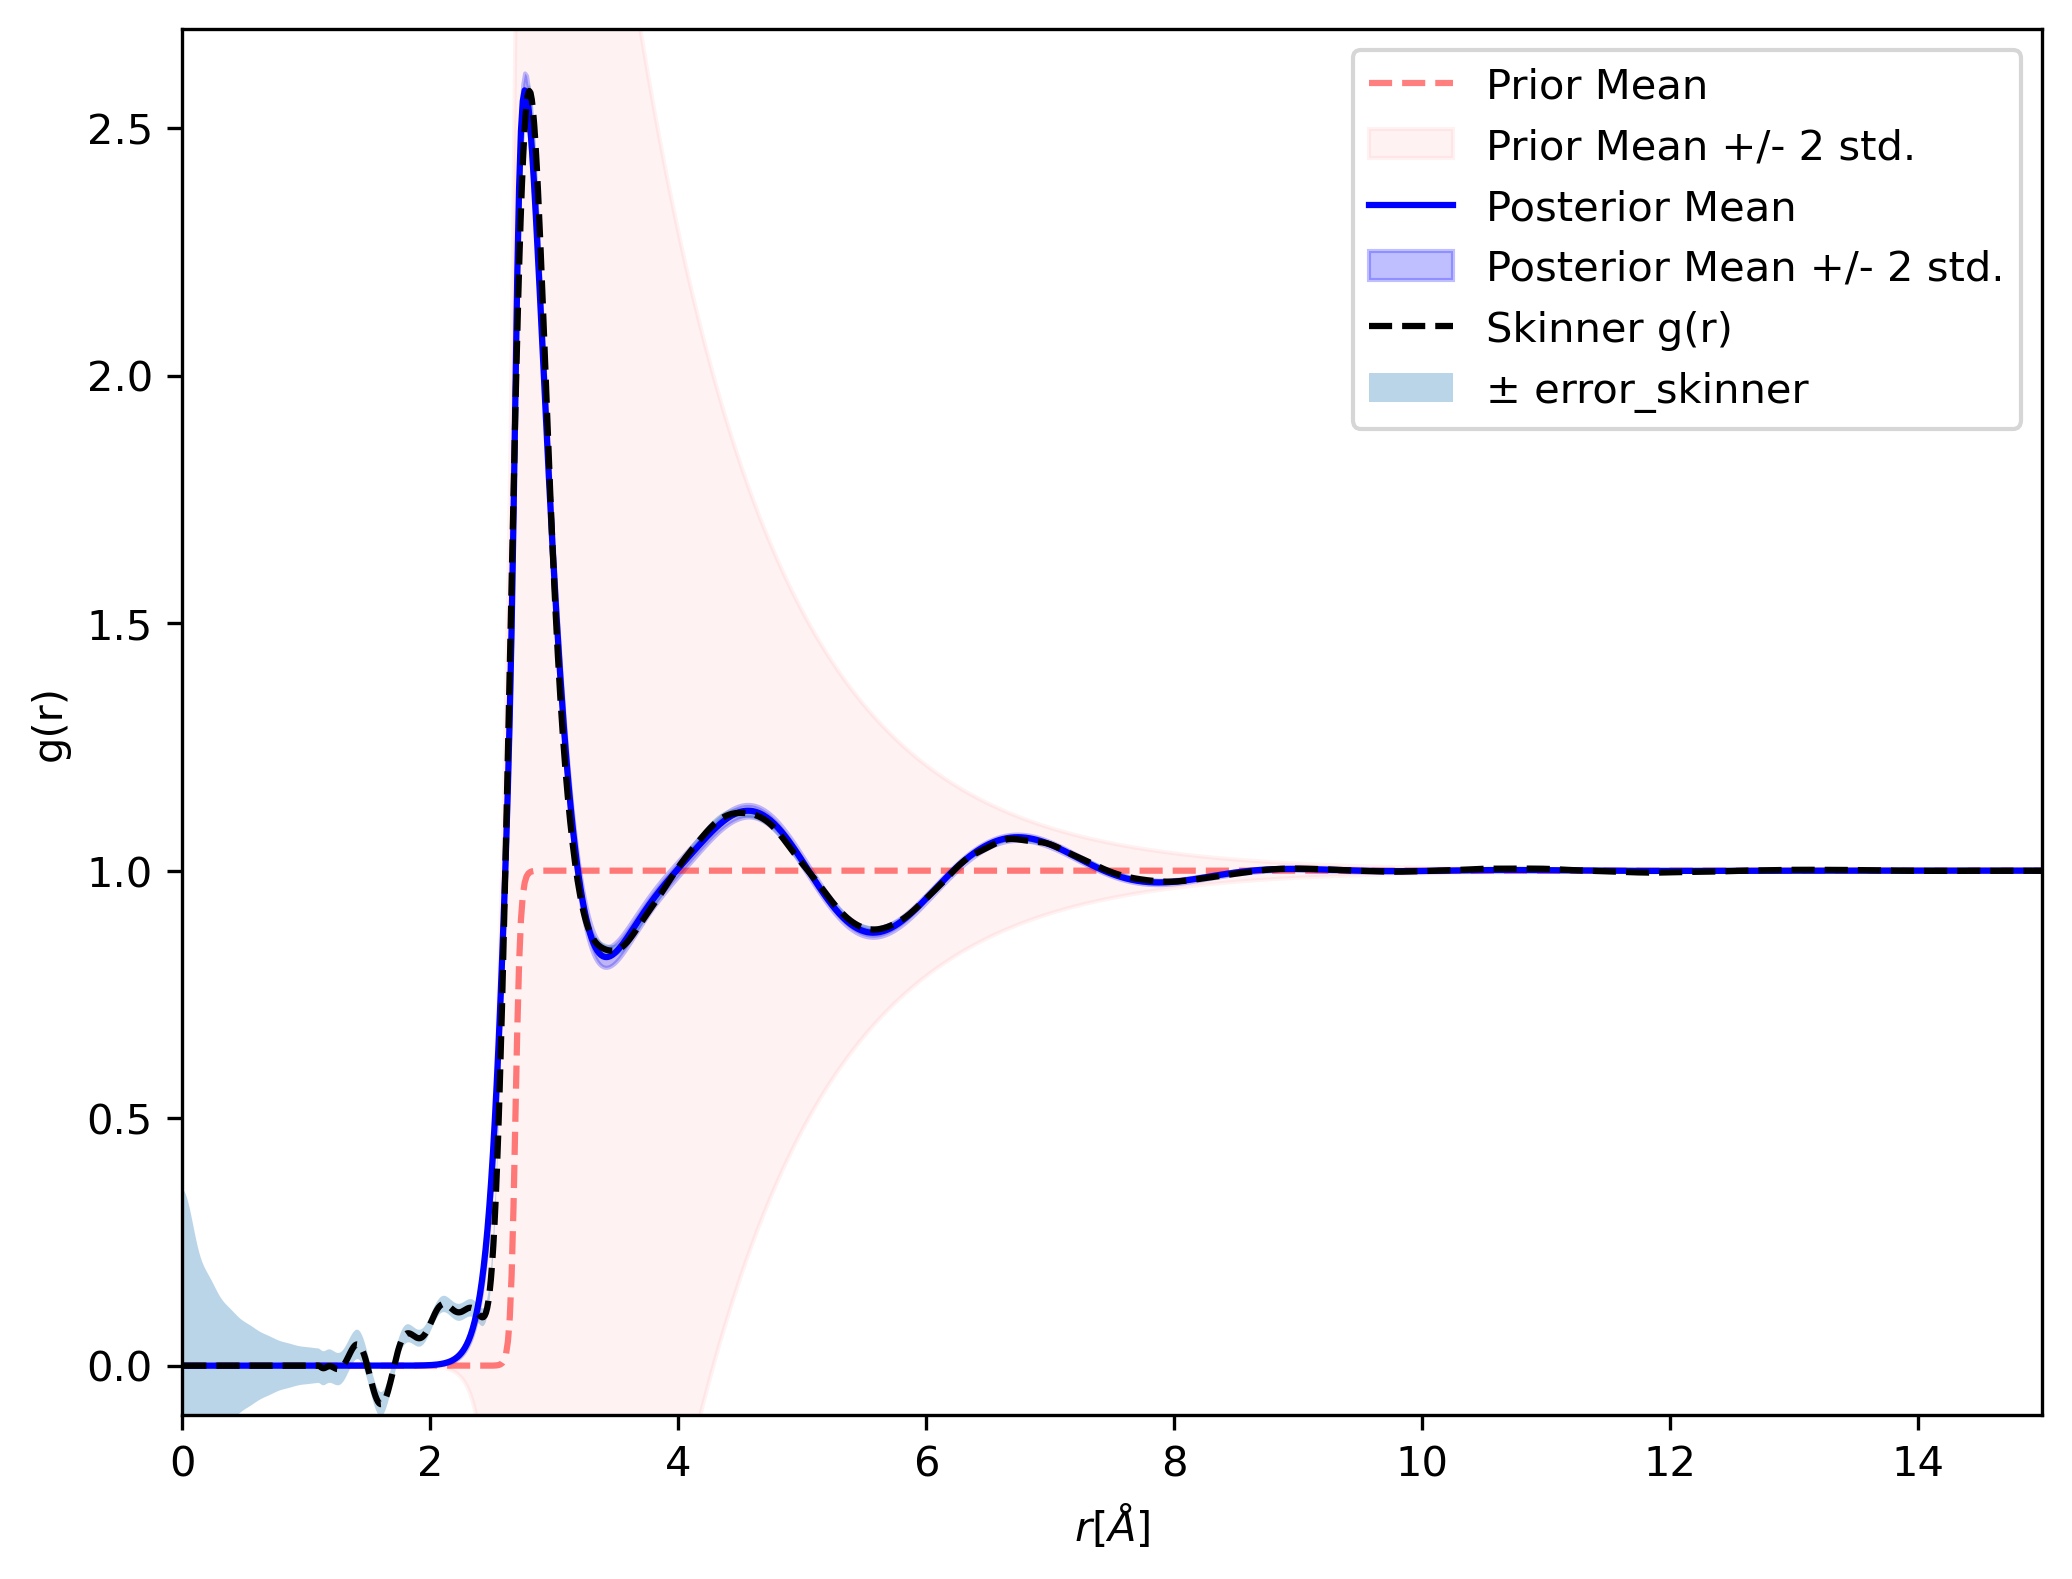

In [202]:
with torch.no_grad():
    r_infer = torch.linspace(0, 15, 1000).reshape(-1,1)
    plt.figure(figsize=(8, 6), dpi=300)

    # Calculate Prior Mean and Cov
    Σ_r_prior = gp.K_rr(r_infer,r_infer).detach()
    μ_r_prior = gp.mean_r(r_infer).detach()

    # Calculate Posterior Mean and Cov
    μ_r_post, Σ_r_post = gp.predict_rdf_trapz(r_grid, r_infer, q_train, sq_train,adjust=False)
    μ_r_post = μ_r_post.detach()
    Σ_r_post = Σ_r_post.detach()
    
    #plt.plot(r_infer.T[0], gptransform.sq2rdf(q_train.T[0], sq_train.T[0], r_infer.T[0], gp.rho)+1,label='Raw rFT',color='green')

    # Plot Prior
    plt.plot(r_infer.T[0],μ_r_prior.T[0],label="Prior Mean",linestyle='dashed',alpha=0.5,color='r')
    plt.fill_between(r_infer.T[0],μ_r_prior.T[0] + 2*torch.diag(Σ_r_prior)**0.5, μ_r_prior.T[0] - 2*torch.diag(Σ_r_prior)**0.5,alpha=0.05,label="Prior Mean +/- 2 std.",color='r')
    
    # Plot Posterior
    plt.plot(r_infer.T[0],μ_r_post.T[0],label="Posterior Mean",color='b')
    plt.fill_between(r_infer.T[0],μ_r_post.T[0] + 2*torch.diag(Σ_r_post)**0.5, μ_r_post.T[0] - 2*torch.diag(Σ_r_post)**0.5,alpha=0.25,label="Posterior Mean +/- 2 std.",color='b')

    # Skinner
    plt.plot(r,g_OO_skinner,label='Skinner g(r)',linestyle='dashed',color='k')
    plt.fill_between(r, g_OO_skinner - error_skinner, g_OO_skinner + error_skinner, alpha=0.3, label='± error_skinner')
    
    # Plot Settings
    plt.ylim(-0.1,2.7)
    plt.xlim(0,15)
    # plt.title('Argon g(r)')
    plt.xlabel('$r [Å]$')
    plt.ylabel('g(r)')
    plt.legend()
    plt.savefig("figs/OO_gr_post.png")

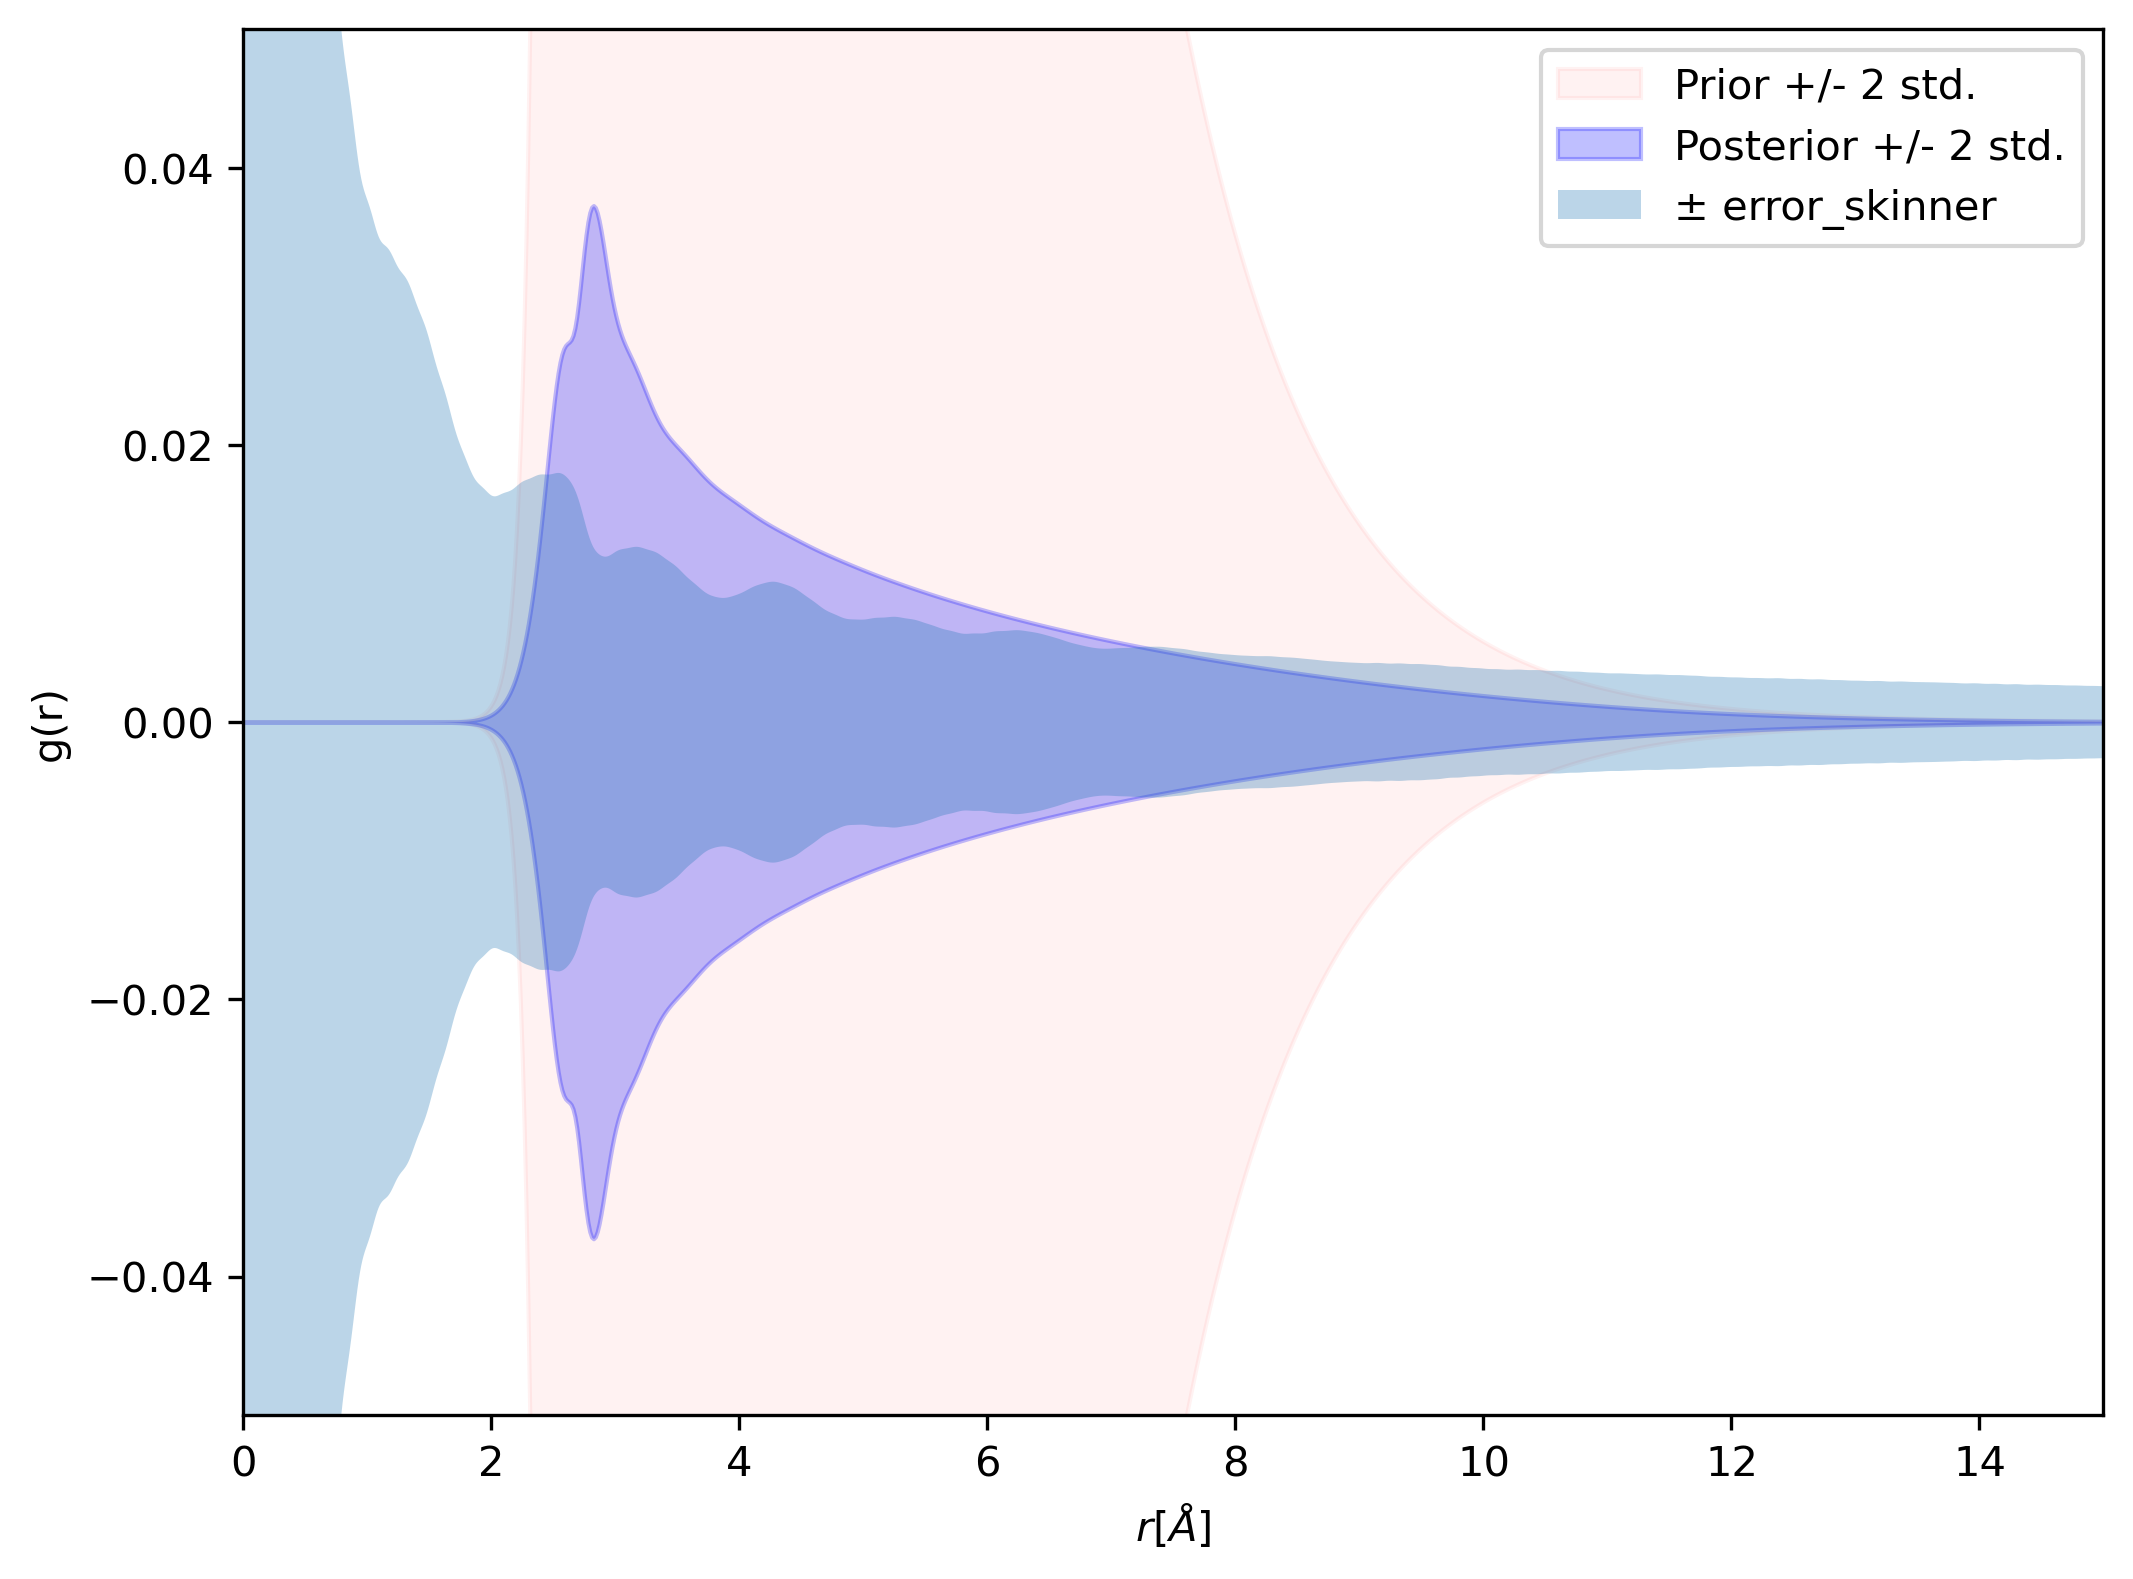

In [7]:
with torch.no_grad():
    r_infer = torch.linspace(0, 15, 1000).reshape(-1,1)
    plt.figure(figsize=(8, 6), dpi=300)

    
    # Plot Prior
    plt.fill_between(r_infer.T[0], 2*torch.diag(Σ_r_prior)**0.5, -2*torch.diag(Σ_r_prior)**0.5,alpha=0.05,label="Prior +/- 2 std.",color='r')
    
    # Plot Posterior
    plt.fill_between(r_infer.T[0], 2*torch.diag(Σ_r_post)**0.5,-2*torch.diag(Σ_r_post)**0.5,alpha=0.25,label="Posterior +/- 2 std.",color='b')

    # Skinner
    plt.fill_between(r, error_skinner,- error_skinner, alpha=0.3, label='± error_skinner')
    
    # Plot Settings
    plt.ylim(-0.05,0.05)
    plt.xlim(0,15)
    # plt.title('Argon g(r)')
    plt.xlabel('$r [Å]$')
    plt.ylabel('g(r)')
    plt.legend()
    plt.savefig("figs/OO_gr_post.png")

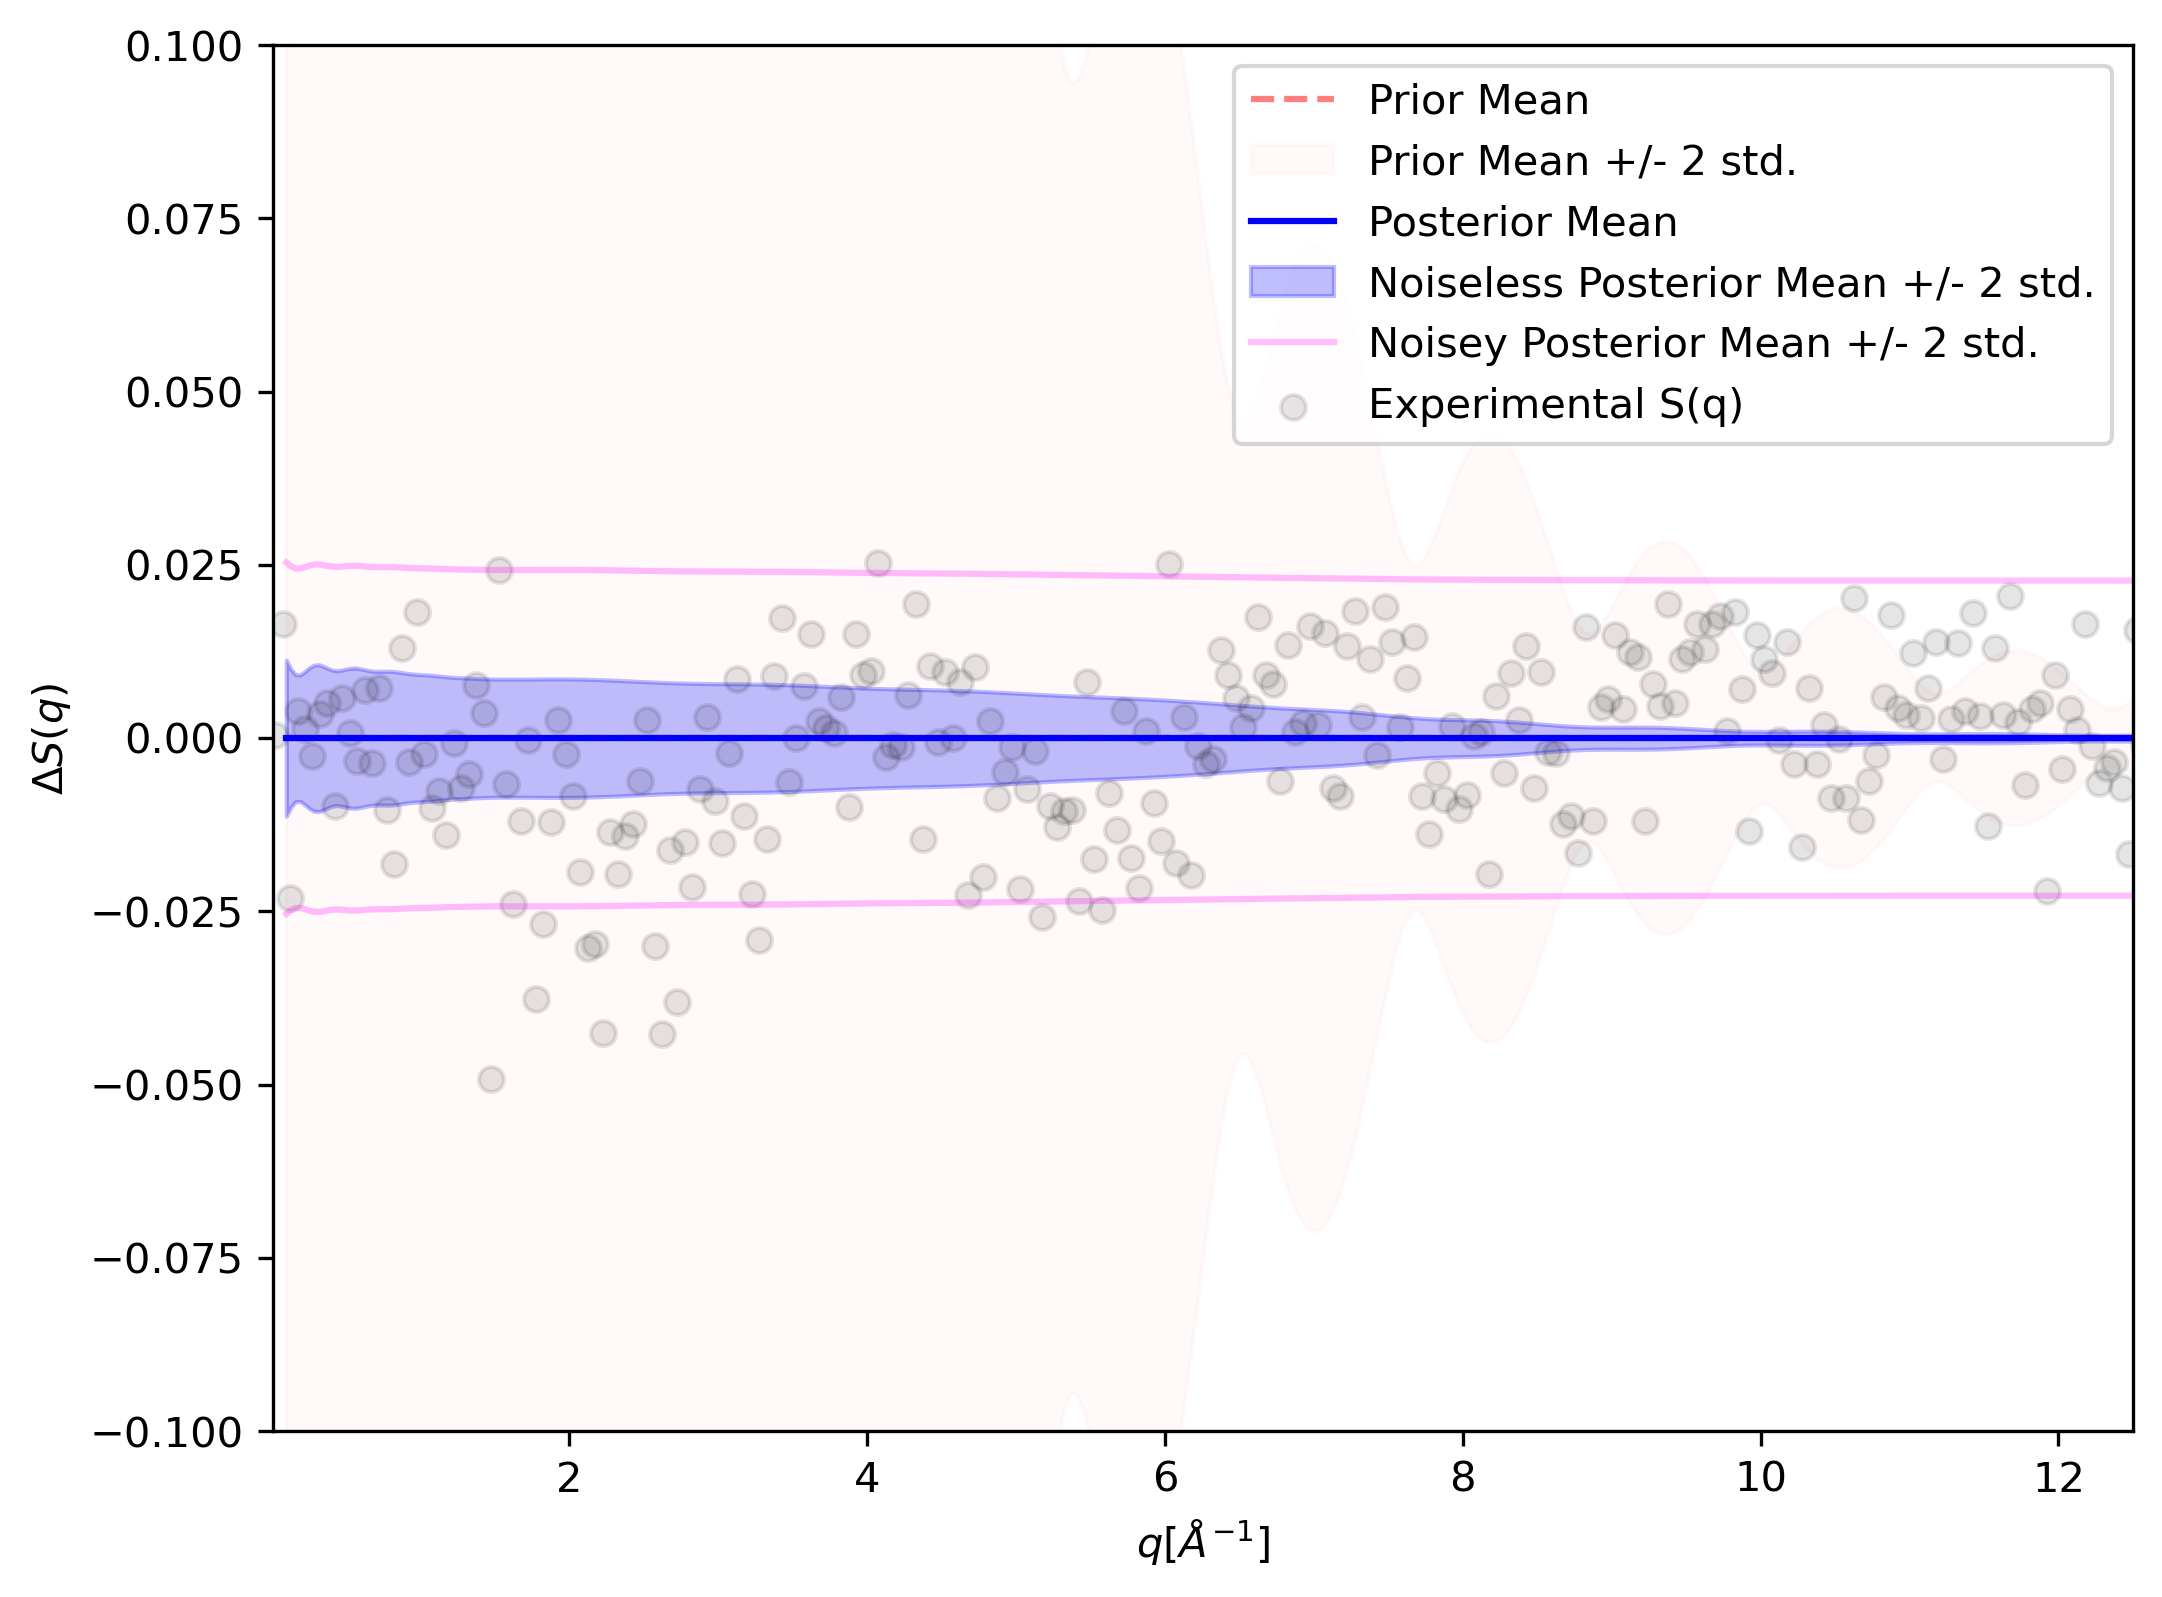

In [8]:
with torch.no_grad():
    

    plt.figure(figsize=(8, 6), dpi=300)

    # Calculate Prior Mean and Cov
    Σ_q_prior = gp.K_qq(r_grid,r_grid,q_infer,q_infer).detach()
    μ_q_prior = gp.mean_q(r_grid,q_infer).detach()

    # Calculate Posterior Mean and Cov
    μ_q_post, Σ_q_post = gp.predict_sq_trapz(r_grid, q_infer, q_train, sq_train,adjust=False)
    μ_q_post = μ_q_post.detach()
    Σ_q_post = Σ_q_post.detach()

    # Plot Prior
    plt.plot(q_infer.T[0],torch.zeros_like(q_infer.T[0]),label="Prior Mean",linestyle='dashed',alpha=0.5,color='r')
    plt.fill_between(q_infer.T[0], 2*torch.diag(Σ_q_prior)**0.5, -2*torch.diag(Σ_q_prior)**0.5,alpha=0.025,label="Prior Mean +/- 2 std.",color='r')

    # Plot Posterior
    plt.plot(q_infer.T[0],torch.zeros_like(q_infer.T[0]),label="Posterior Mean",color='b')
    plt.fill_between(q_infer.T[0],2*torch.diag(Σ_q_post)**0.5,  -2*torch.diag(Σ_q_post)**0.5,alpha=0.25,label="Noiseless Posterior Mean +/- 2 std.",color='b')
    plt.plot(q_infer.T[0],2*torch.diag(Σ_q_post + torch.eye(len(q_infer))*(gp.theta[5]**2))**0.5,alpha=0.25,label="Noisey Posterior Mean +/- 2 std.",color='magenta')
    plt.plot(q_infer.T[0],-2*torch.diag(Σ_q_post + torch.eye(len(q_infer))*(gp.theta[5]**2))**0.5,alpha=0.25,color='magenta')

    q_infer = q_train
        
    # Calculate Prior Mean and Cov
    Σ_q_prior = gp.K_qq(r_grid,r_grid,q_infer,q_infer).detach()
    μ_q_prior = gp.mean_q(r_grid,q_infer).detach()

    # Calculate Posterior Mean and Cov
    μ_q_post, Σ_q_post = gp.predict_sq_trapz(r_grid, q_infer, q_train, sq_train,adjust=False)
    μ_q_post = μ_q_post.detach()
    Σ_q_post = Σ_q_post.detach()    
        
    #plt.plot((torch.unsqueeze(torch.tensor(my_data.T[0]),dim=1)[1:].float()).T[0],(torch.unsqueeze(torch.tensor(my_data.T[1]),dim=1)[1:].float() - 1).T[0],label='True S(q)',linestyle='dashdot',color='k')
    # Experimental Data
    plt.scatter(q_train,sq_train-μ_q_post,label='Experimental S(q)',alpha=0.1,color='k')
    
    
    # Plot Settings
    plt.xlim(0.01,12.5)
    plt.ylim(-0.1,0.1)

    plt.xlabel('$q [Å^{-1}]$')
    plt.ylabel('$\Delta S(q)$')
    plt.legend()
    plt.savefig("figs/OO_sq_post_residual.png")

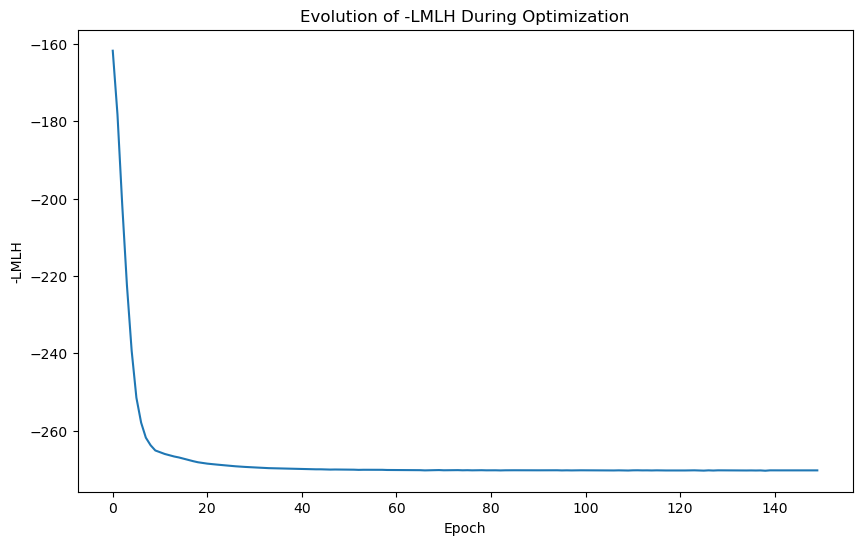

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(torch.tensor(losses).view(150, 5).mean(dim=1), linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('-LMLH')
plt.title('Evolution of -LMLH During Optimization')
plt.savefig('figs/'+psq_name+'_LMLH.png')
plt.show()

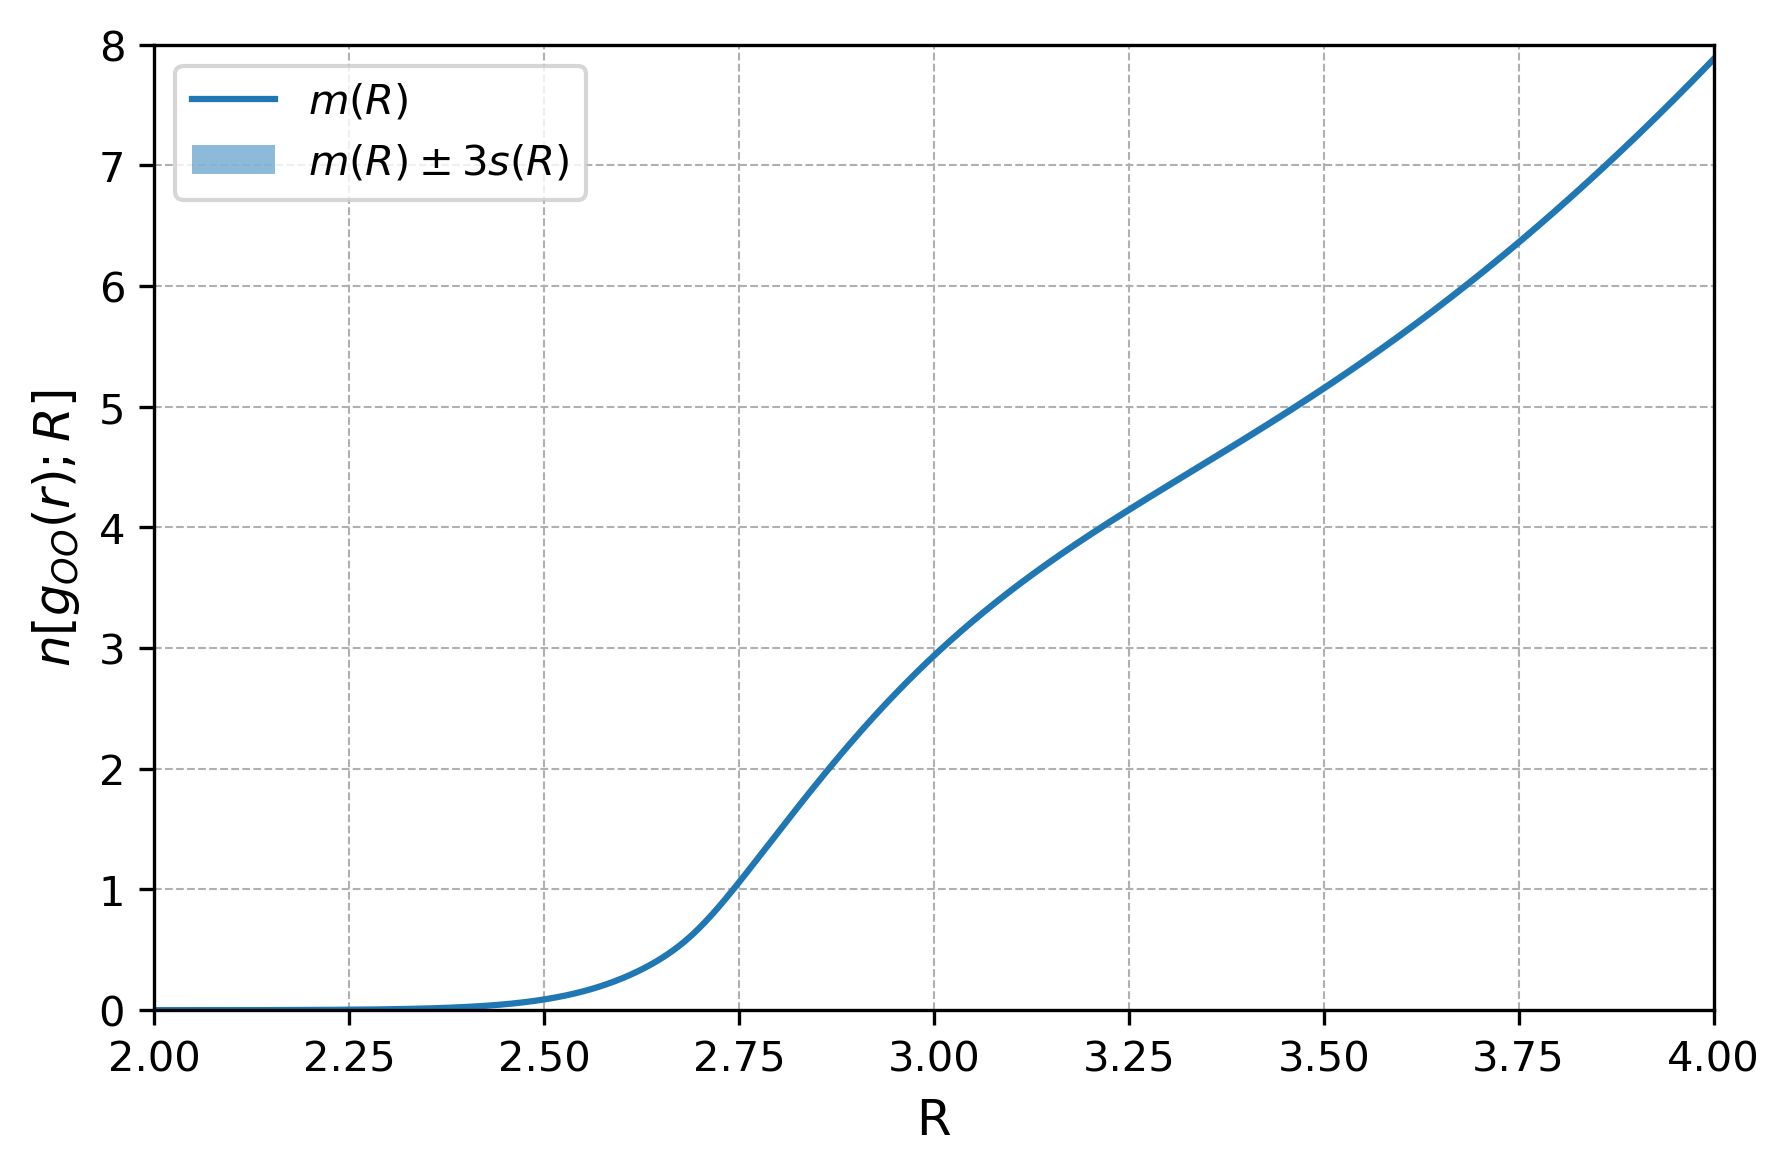

In [206]:
plt.figure(figsize=(6, 4),dpi=300)
with torch.no_grad():
    r_infer = torch.linspace(2, 6, 2000).reshape(-1,1)
    # Calculate Posterior Mean and Cov
    μ_r_post, Σ_r_post = gp.predict_rdf_trapz(r_grid, r_infer, q_train, sq_train,adjust=False)
    μ_r_post = μ_r_post.detach()
    Σ_r_post = Σ_r_post.detach()

    dr = (r_infer[1] - r_infer[0]).item() # Stepsize
    n_μ  = torch.zeros(len(r_infer))
    for j in range (len(r_infer)):
        n_μ[j] = 4*np.pi*density*torch.trapz(((r_infer[:j]**2)*μ_r_post[:j]).reshape(-1),dx = dr)

    n_σ = torch.zeros(len(r_infer))
    rr_prime = torch.outer(r_infer.T[0],r_infer.T[0])   
    for j in range (len(r_infer)):
        n_σ[j] = ((4*np.pi*density)**2*torch.trapz(torch.trapz(Σ_r_post[:j,:j]*rr_prime[:j:,:j]**2,dx = dr),dx=dr))**0.5

plt.plot(r_infer, n_μ, linestyle='-',label="$m(R)$")
plt.fill_between(r_infer.T[0], n_μ+3*n_σ, n_μ-3*n_σ,alpha=0.5,label="$m(R) \pm 3s(R)$")
plt.xlabel('R', fontsize=12)
plt.ylabel('$n[g_{OO}(r);R]$', fontsize=12)
# plt.title('Plot of $n[g(r);R]$ vs r', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend()
plt.xlim(2,4)
plt.ylim(0,8)
plt.show()

In [207]:
dist = torch.distributions.MultivariateNormal(μ_r_post.reshape(-1), covariance_matrix=gp.nearestPD(Σ_r_post))
samples = dist.sample((50_000,))  

N, d = samples.shape
threshold = 0.1  # local maxima must be above this threshold

# Compute local maxima mask
left = samples[:, :-2]
mid = samples[:, 1:-1]
right = samples[:, 2:]
is_local_max = (mid > left) & (mid > right) & (mid > threshold)

# Pad to match shape (N, d)
local_maxima_mask = torch.cat([
    torch.zeros((N, 1), dtype=torch.bool),
    is_local_max,
    torch.zeros((N, 1), dtype=torch.bool)
], dim=1)

# Store first 3 maxima indices and valley *indices* between them
maxima_indices = torch.full((N, 3), -1, dtype=torch.long)
valley_indices = torch.full((N, 2), -1, dtype=torch.long)

for i in range(N):
    idxs = torch.where(local_maxima_mask[i])[0]
    num = min(3, len(idxs))
    if num > 0:
        maxima_indices[i, :num] = idxs[:num]
        if num >= 2:
            a, b = idxs[0].item(), idxs[1].item()
            if b > a + 1:
                segment = samples[i, a+1:b]
                min_idx = torch.argmin(segment).item() + a + 1
                valley_indices[i, 0] = min_idx
        if num == 3:
            b, c = idxs[1].item(), idxs[2].item()
            if c > b + 1:
                segment = samples[i, b+1:c]
                min_idx = torch.argmin(segment).item() + b + 1
                valley_indices[i, 1] = min_idx

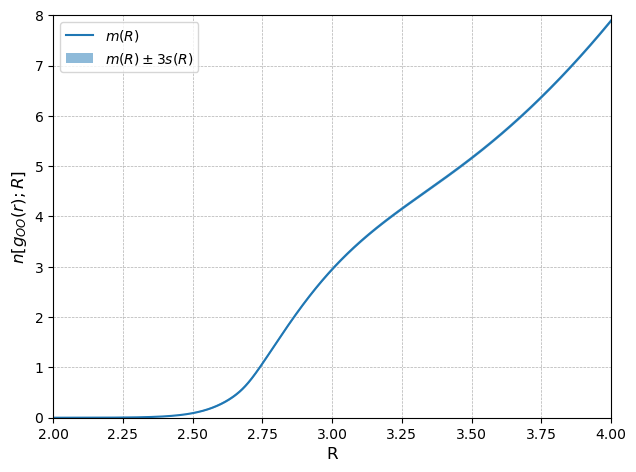

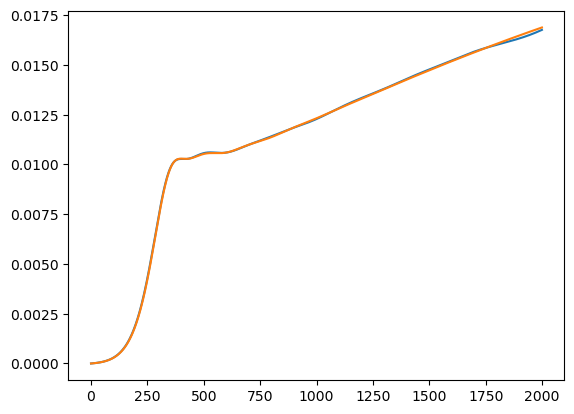

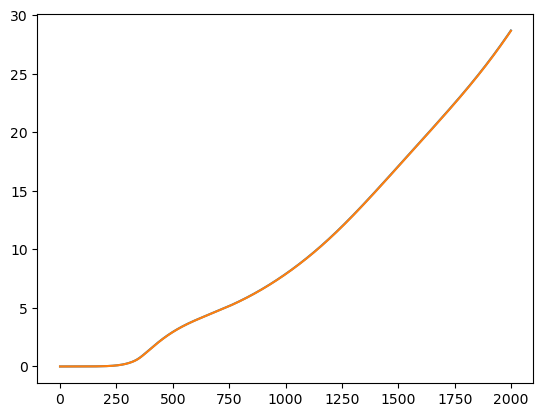

In [208]:
# Quick test of a monte carlo scheme to see if the numerical integral I did before was right
# Sanity check really.
integrand = samples * (4 * np.pi * density * r_infer.T.expand(50_000, -1)**2)

# Compute cumulative integrals using trapezoid rule
trap_mid = 0.5 * (integrand[:, 1:] + integrand[:, :-1])  # shape: (N, D-1)
n_func_samples = torch.zeros_like(samples)  # shape: (N, D)
n_func_samples[:, 1:] = torch.cumsum(trap_mid * dr, dim=1)

mc_mean = n_func_samples.mean(dim=0)
mc_std = n_func_samples.std(dim=0,unbiased=True)

plt.plot(r_infer, mc_mean, linestyle='-',label="$m(R)$")
plt.fill_between(r_infer.T[0], mc_mean+3*mc_std, mc_mean-3*mc_std,alpha=0.5,label="$m(R) \pm 3s(R)$")
plt.xlabel('R', fontsize=12)
plt.ylabel('$n[g_{OO}(r);R]$', fontsize=12)
# plt.title('Plot of $n[g(r);R]$ vs r', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend()
plt.xlim(2,4)
plt.ylim(0,8)
plt.show()

plt.plot(mc_std)
plt.plot(n_σ)
plt.show()

plt.plot(mc_mean)
plt.plot(n_μ)
plt.show()

In [209]:
# Calculate Posterior Mean and Cov
dr = (r_infer[1] - r_infer[0]).item() # Stepsize
n_samples  = torch.zeros(50_000)
r_1_samples = torch.zeros(50_000)
peak_locs = torch.zeros(50_000,2)
peak_heights = torch.zeros(50_000,2)
for j in range (len(n_samples)):
    dr = (r_infer[1] - r_infer[0]).item() # Stepsize
    r_1 = valley_indices[j,0]
    r_1_samples[j] = r_infer[r_1]
    n_samples[j] = 4*np.pi*density*torch.trapz(((r_infer[:r_1].reshape(-1)**2)*samples[j][:r_1]),dx = dr)
    peak_locs[j,1] = r_infer[maxima_indices[j,1]]
    peak_heights[j,1] = samples[j,maxima_indices[j,1]]

In [210]:
r_infer_peak_height = torch.linspace(2.75, 2.77, 2000).reshape(-1,1)
μ_r_post, Σ_r_post = gp.predict_rdf_trapz(r_grid, r_infer_peak_height, q_train, sq_train,adjust=False)
μ_r_post = μ_r_post.detach()
Σ_r_post = Σ_r_post.detach()

dist = torch.distributions.MultivariateNormal(μ_r_post.reshape(-1), covariance_matrix=gp.nearestPD(Σ_r_post))
samples = dist.sample((50_000,))  

N, d = samples.shape
threshold = 0.1  # local maxima must be above this threshold

# Compute local maxima mask
left = samples[:, :-2]
mid = samples[:, 1:-1]
right = samples[:, 2:]
is_local_max = (mid > left) & (mid > right) & (mid > threshold)

# Pad to match shape (n_samples, d)
local_maxima_mask = torch.cat([
    torch.zeros((N, 1), dtype=torch.bool),
    is_local_max,
    torch.zeros((N, 1), dtype=torch.bool)
], dim=1)

# Store first 3 maxima indices and valley *indices* between them
maxima_indices = torch.full((N, 3), -1, dtype=torch.long)
valley_indices = torch.full((N, 2), -1, dtype=torch.long)

for i in range(N):
    idxs = torch.where(local_maxima_mask[i])[0]
    num = min(3, len(idxs))
    if num > 0:
        maxima_indices[i, :num] = idxs[:num]
        if num >= 2:
            a, b = idxs[0].item(), idxs[1].item()
            if b > a + 1:
                segment = samples[i, a+1:b]
                min_idx = torch.argmin(segment).item() + a + 1
                valley_indices[i, 0] = min_idx
        if num == 3:
            b, c = idxs[1].item(), idxs[2].item()
            if c > b + 1:
                segment = samples[i, b+1:c]
                min_idx = torch.argmin(segment).item() + b + 1
                valley_indices[i, 1] = min_idx
                

for j in range (50_000):
    peak_locs[j,0] = r_infer_peak_height[maxima_indices[j,0]]
    peak_heights[j,0] = samples[j,maxima_indices[j,0]]

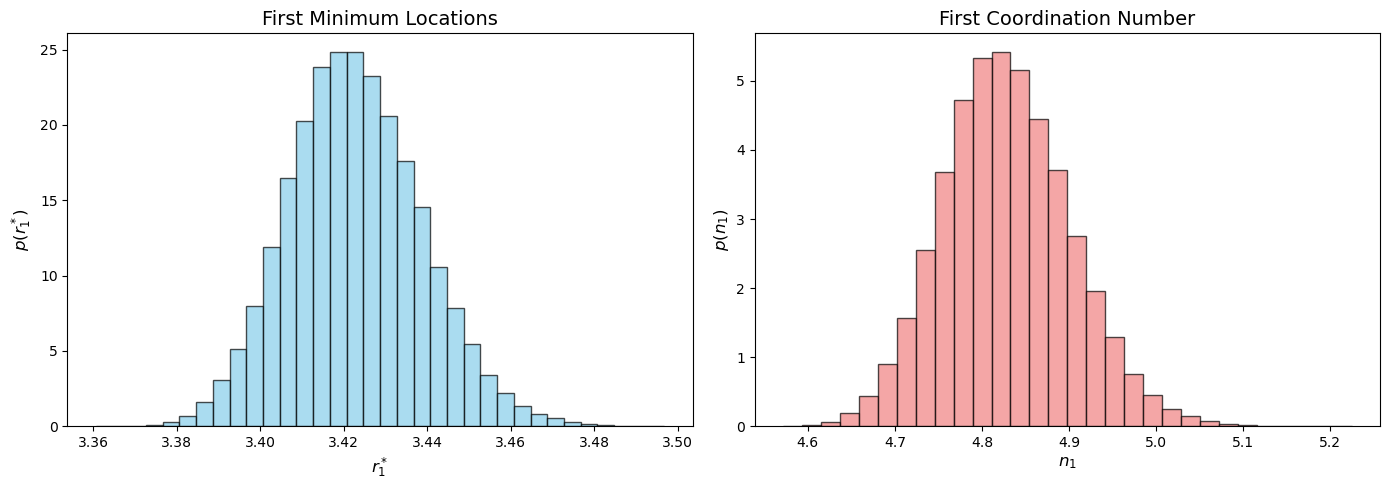

In [211]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# First subplot: r_1_samples
axs[0].hist(r_1_samples, bins=r_infer.T[0][680:750:2], density=True, color='skyblue', edgecolor='black', alpha=0.7)
axs[0].set_xlabel(r'$r_1^*$', fontsize=12)
axs[0].set_ylabel('$p(r_1^*)$', fontsize=12)
axs[0].set_title('First Minimum Locations', fontsize=14)

# Second subplot: n_samples
axs[1].hist(n_samples, bins=30, density=True, color='lightcoral', edgecolor='black', alpha=0.7)
axs[1].set_xlabel(r'$n_1$', fontsize=12)
axs[1].set_ylabel('$p(n_1)$', fontsize=12)
axs[1].set_title('First Coordination Number', fontsize=14)

plt.tight_layout()
plt.show()


/var/folders/tv/1d811xv917v4wz50x1bqpvcc0000gn/T/ipykernel_19703/3930988794.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.85])  # Leave room for stats table and colorbar


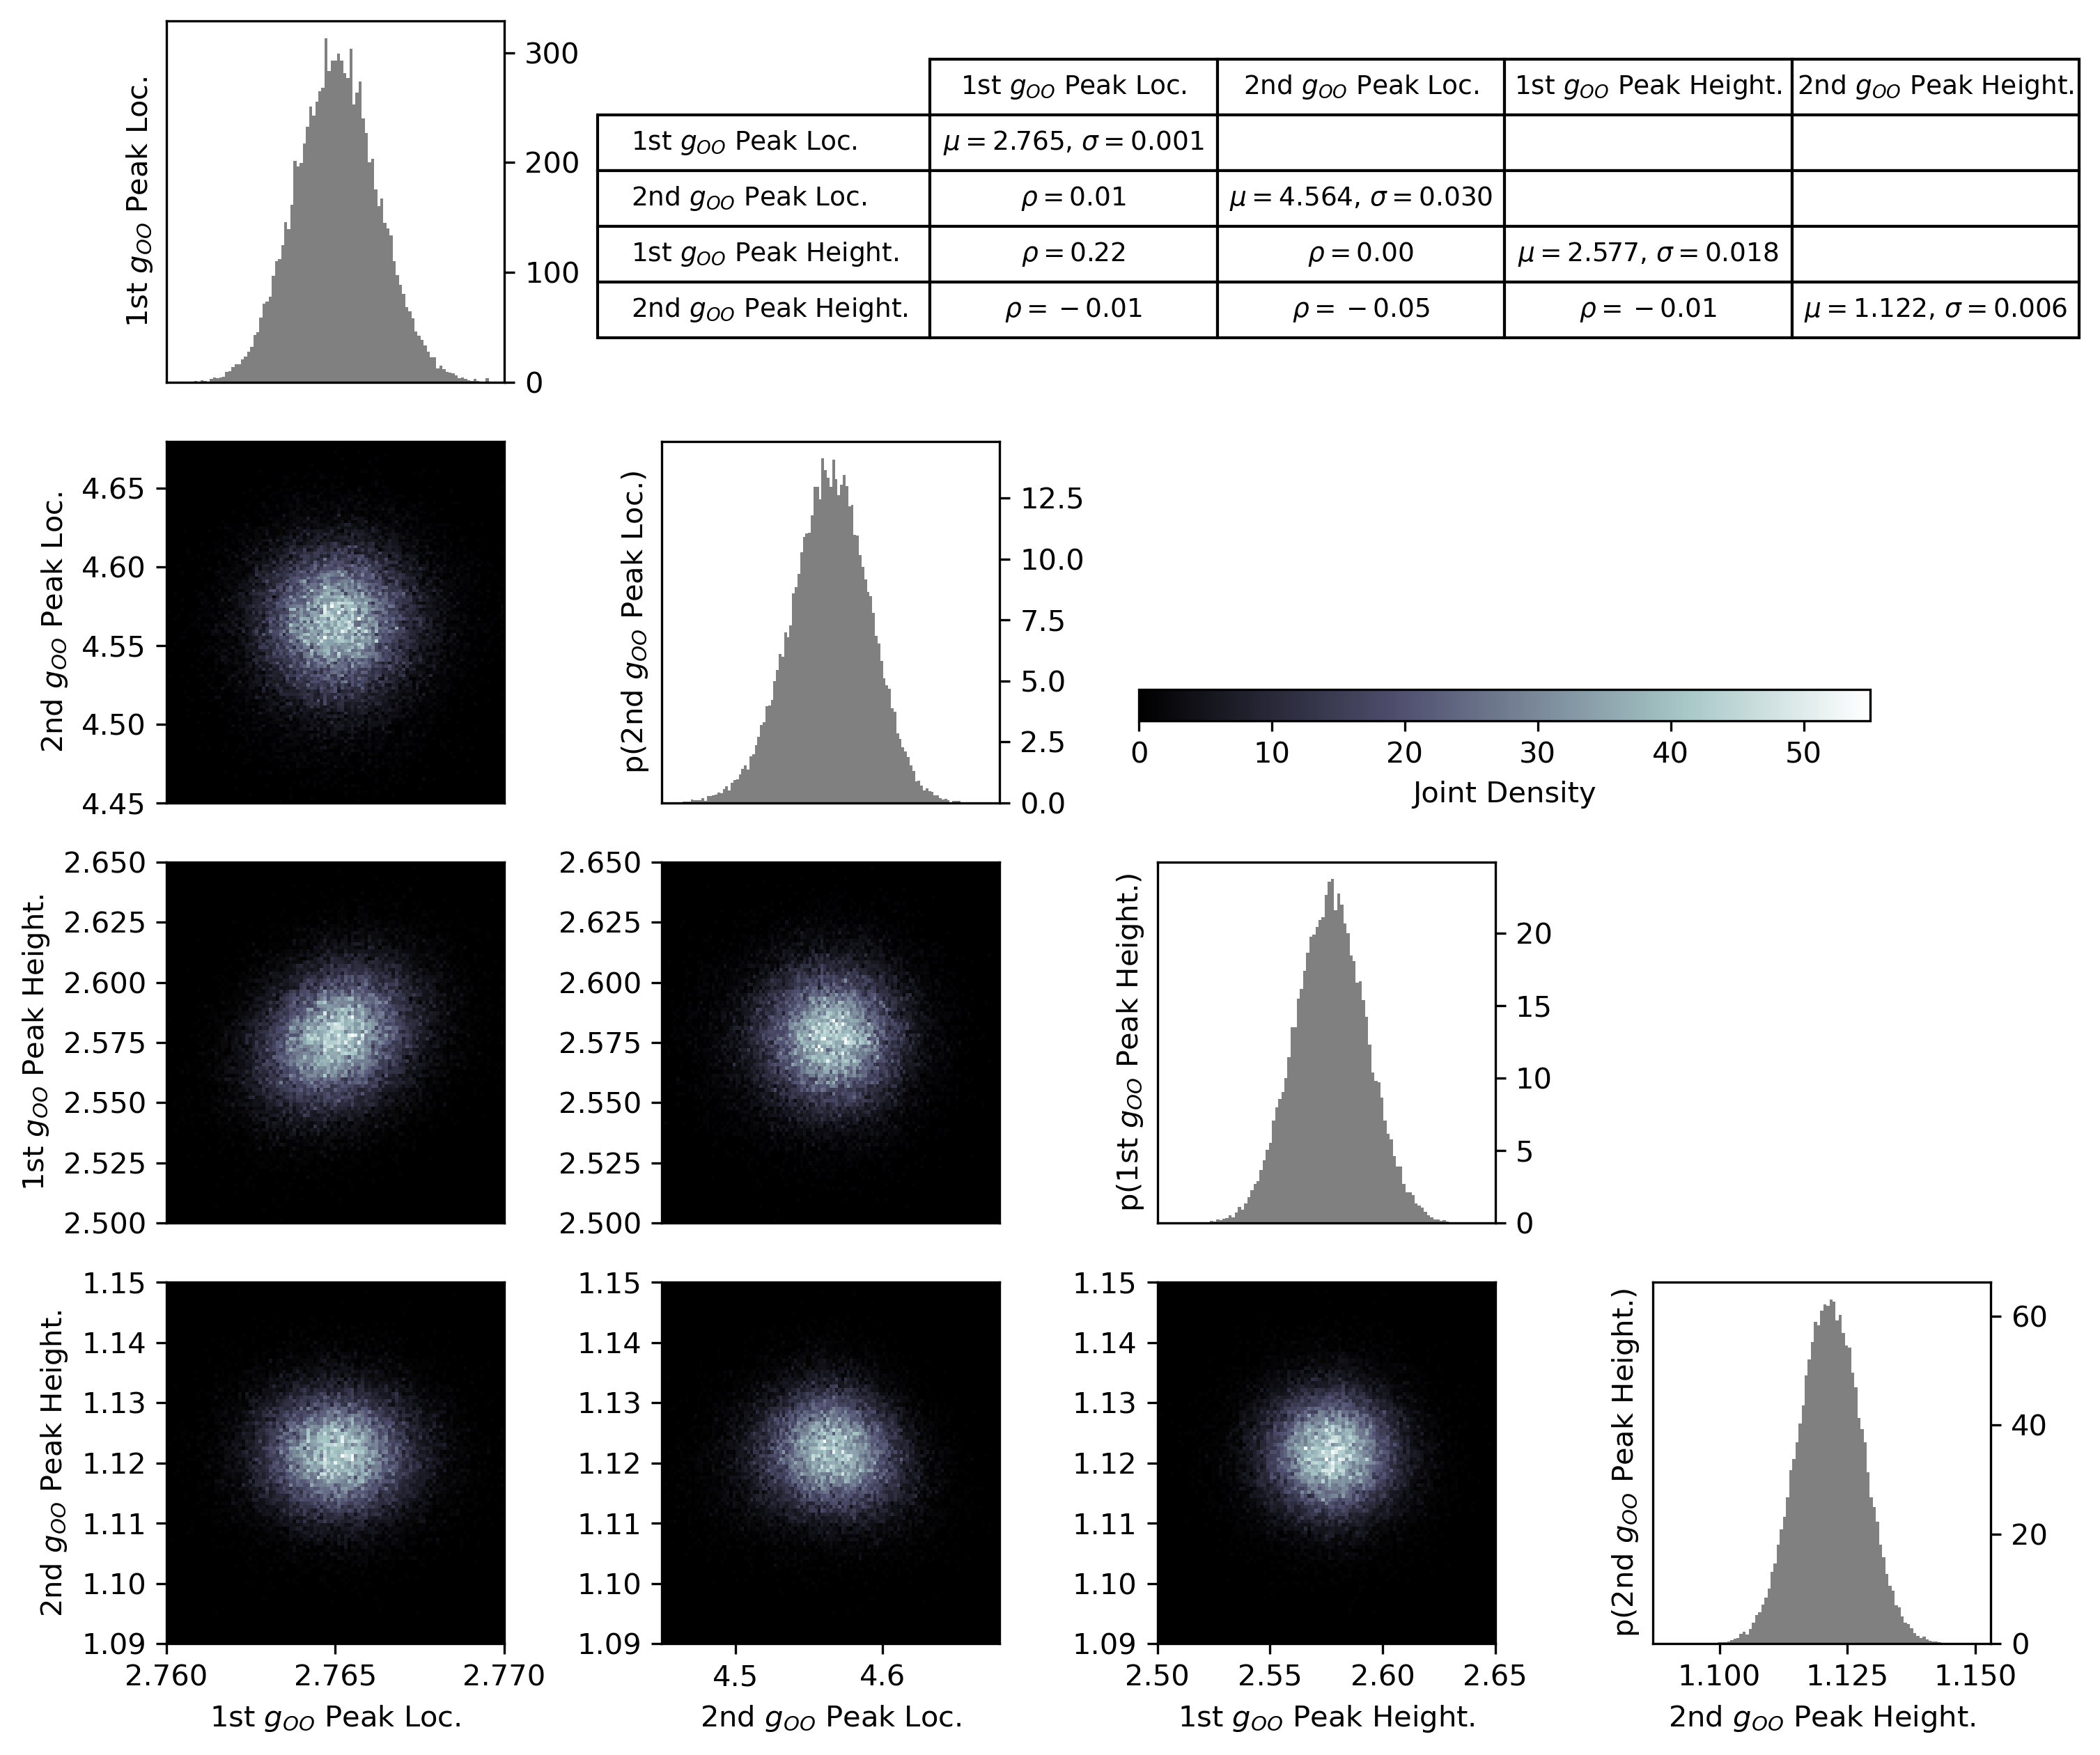

In [212]:
# Combine data
data = torch.cat([peak_locs, peak_heights], dim=1).numpy()
labels = [
    "1st $g_{OO}$ Peak Loc.",
    "2nd $g_{OO}$ Peak Loc.",
    "1st $g_{OO}$ Peak Height.",
    "2nd $g_{OO}$ Peak Height."
]
n_dims = data.shape[1]

# Define bin edges for each parameter
bin_edges = [
    np.linspace(2.76, 2.77, 100),
    np.linspace(4.45, 4.68, 116),
    np.linspace(2.5, 2.65, 100),
    np.linspace(1.09, 1.15, 100),
]

# Compute summary statistics
means = np.mean(data, axis=0)
stds = np.std(data, axis=0)
corr_matrix = np.corrcoef(data.T)

# Create subplot grid
fig, axes = plt.subplots(n_dims, n_dims, figsize=(10, 10),dpi = 300)
plt.subplots_adjust(hspace=0.05, wspace=0.05)

# Store the QuadMesh from the first hist2d for the colorbar
quadmesh = None

for i in range(n_dims):
    for j in range(n_dims):
        ax = axes[i, j]
        if i == j:
            ax.hist(data[:, i], bins=bin_edges[i], color='gray', density=True)
            ax.set_ylabel(f"p({labels[i]})")
        elif i > j:
            h = ax.hist2d(
                data[:, j], data[:, i],
                bins=[bin_edges[j], bin_edges[i]],
                cmap='bone'
            )
            if quadmesh is None:
                quadmesh = h[3]
        else:
            ax.axis("off")
        
        if j == 0:
            ax.set_ylabel(labels[i])

        # Tick labels
        if i == n_dims - 1:
            ax.set_xlabel(labels[j])
        else:
            ax.set_xticks([])
            
        if i == j:
            ax.yaxis.tick_right()

# --- Add summary statistics table in whitespace ---
# Format content for the table
cell_text = []
for i in range(n_dims):
    row = []
    for j in range(n_dims):
        if i == j:
            row.append(f"$\\mu={means[i]:.3f}$, $\\sigma={stds[i]:.3f}$")
        elif i > j:
            row.append(f"$\\rho={corr_matrix[i, j]:.2f}$")
        else:
            row.append("")
    cell_text.append(row)

# Table axes (place above diagonal region)
table_ax = fig.add_axes([0.45, 0.7, 0.55, 0.1])  # [left, bottom, width, height]
table_ax.axis('off')
the_table = table_ax.table(
    cellText=cell_text,
    rowLabels=labels,
    colLabels=labels,
    loc='center',
    cellLoc='center'
)
the_table.scale(1, 1.6)
the_table.auto_set_font_size(False)
the_table.set_fontsize(9)

# Add colorbar
cbar_ax = fig.add_axes([0.55, 0.5, 0.35, 0.015])
cbar = fig.colorbar(quadmesh, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Joint Density")

plt.tight_layout(rect=[0, 0, 1, 0.85])  # Leave room for stats table and colorbar
plt.show()